# Setup and Preprocessing

## Load code and data

In [2]:
## import code
# basics and plotting
import re
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# preprocessing
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_sample_weight

# cross validation and modeling
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.dummy import DummyClassifier
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PoissonRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_predict

# tuning
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import validation_curve

# staticial comparison of model performance
# see https://github.com/janezd/baycomp
# to install library:
# pip install baycomp
from baycomp.single import two_on_single

# feature importance
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [2]:
# load original data set into a dataframe
data = pd.read_csv("cleaned_cope_data_randomized_corrected2.csv", dtype={'b_bstad_me_30_days_8': 'str', 'b_bstad_me_90_days_6': 'str', 'b_bstad_me_90_days_8': 'str'})

In [3]:
# alternatively, load preprocessed data set into a dataframe
data = pd.read_csv('data_preproc.csv')

## Initial data exploration, reduction, and imputation

In [3]:
# general info including rows and columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Columns: 544 entries, Unnamed: 0 to b_uls_tot
dtypes: float64(421), int64(60), object(63)
memory usage: 10.2+ MB


In [4]:
# reduce to columns of interest
data = data[['b_uls_tot', 'b_cdi_tot', 'b_dem_sex', 'b_dem_gender', 'b_dem_orientation', 
             'b_bads_tot', 'b_shs_tot' , 'b_bhs_tot', 'b_aces_tot' , 'b_mvps_tot', 
             'eds_events_tot', 'b_gad_tot', 'b_sitbi_2',  'b_sitbi_8', 
             'b_sitbi_nssi_year_1', 'b_sitbi_si_year_1', 'b_sitbi_attempt_year_1', 'b_sitbi_17']]

# more detail about columns of interest 
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   b_uls_tot               2446 non-null   float64
 1   b_cdi_tot               2448 non-null   float64
 2   b_dem_sex               2452 non-null   object 
 3   b_dem_gender            2452 non-null   object 
 4   b_dem_orientation       2452 non-null   object 
 5   b_bads_tot              2448 non-null   float64
 6   b_shs_tot               2450 non-null   float64
 7   b_bhs_tot               2451 non-null   float64
 8   b_aces_tot              2447 non-null   float64
 9   b_mvps_tot              2447 non-null   float64
 10  eds_events_tot          2448 non-null   float64
 11  b_gad_tot               2447 non-null   float64
 12  b_sitbi_2               2451 non-null   float64
 13  b_sitbi_8               2452 non-null   int64  
 14  b_sitbi_nssi_year_1     1604 non-null   

In [5]:
# give columns more intuitive names
data.rename(columns = {'b_uls_tot':'loneliness', 'b_cdi_tot':'depression', 'b_dem_sex':'sex',
                        'b_dem_gender':'gender', 'b_dem_orientation':'orientation', 'b_bads_tot':'behav_act',
                        'b_shs_tot':'hope', 'b_bhs_tot':'hopelessness', 'b_aces_tot':'child_adverse',
                        'b_mvps_tot':'peer_vict', 'eds_events_tot':'discrimination', 
                        'b_gad_tot':'anxiety', 'b_sitbi_2':'nssi_bin', 'b_sitbi_8':'si_bin',
                        'b_sitbi_nssi_year_1':'nssi_year', 'b_sitbi_si_year_1':'si_year',
                        'b_sitbi_attempt_year_1':'attempt_year', 'b_sitbi_17':'attempt_bin'}, inplace = True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   loneliness      2446 non-null   float64
 1   depression      2448 non-null   float64
 2   sex             2452 non-null   object 
 3   gender          2452 non-null   object 
 4   orientation     2452 non-null   object 
 5   behav_act       2448 non-null   float64
 6   hope            2450 non-null   float64
 7   hopelessness    2451 non-null   float64
 8   child_adverse   2447 non-null   float64
 9   peer_vict       2447 non-null   float64
 10  discrimination  2448 non-null   float64
 11  anxiety         2447 non-null   float64
 12  nssi_bin        2451 non-null   float64
 13  si_bin          2452 non-null   int64  
 14  nssi_year       1604 non-null   float64
 15  si_year         1955 non-null   float64
 16  attempt_year    774 non-null    float64
 17  attempt_bin     2452 non-null   i

In [6]:
# missing data counts
data.isnull().sum()

loneliness           6
depression           4
sex                  0
gender               0
orientation          0
behav_act            4
hope                 2
hopelessness         1
child_adverse        5
peer_vict            5
discrimination       4
anxiety              5
nssi_bin             1
si_bin               0
nssi_year          848
si_year            497
attempt_year      1678
attempt_bin          0
dtype: int64

In [7]:
# delete whole samples missing values for nssi_bin, si_bin, or attempt_bin
# these are yes/no target variables with branching logic for whether other target variables were presented
# only nssi_bin has a single missing value
data = data[data['nssi_bin'].notna()]

# confirming drop of 1 sample
data.shape

(2451, 18)

In [8]:
# missing data counts
data.isnull().sum()

loneliness           6
depression           4
sex                  0
gender               0
orientation          0
behav_act            3
hope                 2
hopelessness         1
child_adverse        5
peer_vict            5
discrimination       4
anxiety              5
nssi_bin             0
si_bin               0
nssi_year          848
si_year            497
attempt_year      1677
attempt_bin          0
dtype: int64

In [9]:
# Which missing values for nssi_year can be assumed to be (and imputed as) zero?
print("How many answered no to nssi_bin and are missing value for nssi_year?")
print(data.loc[data['nssi_bin'] == 0, 'nssi_year'].isnull().sum())
print("How many answered yes to nssi_bin and are missing value for nssi_year?")
print(data.loc[data['nssi_bin'] == 1, 'nssi_year'].isnull().sum())

How many answered no to nssi_bin and are missing value for nssi_year?
798
How many answered yes to nssi_bin and are missing value for nssi_year?
50


In [10]:
# Which missing values for si_year can be assumed to be (and imputed as) zero?
print("How many answered no to si_bin and are missing value for si_year?")
print(data.loc[data['si_bin'] == 0, 'si_year'].isnull().sum())
print("How many answered yes to si_bin and are missing value for si_year?")
print(data.loc[data['si_bin'] == 1, 'si_year'].isnull().sum())

How many answered no to si_bin and are missing value for si_year?
461
How many answered yes to si_bin and are missing value for si_year?
36


In [11]:
# Which missing values for attempt_year can be assumed to be (and imputed as) zero?
print("How many answered no to attempt_bin and are missing value for attempt_year?")
print(data.loc[data['attempt_bin'] == 0, 'attempt_year'].isnull().sum())
print("How many answered yes to attempt_bin and are missing value for attempt_year?")
print(data.loc[data['attempt_bin'] == 1, 'attempt_year'].isnull().sum())

How many answered no to attempt_bin and are missing value for attempt_year?
1668
How many answered yes to attempt_bin and are missing value for attempt_year?
9


In [12]:
# replace missing outcome values with zeros where appropriate
# (participant responded they did not engage in the behavior with binary measure)
data.loc[data['nssi_bin'] == 0 & data['nssi_year'].isnull(), 'nssi_year'] = 0
data.loc[data['si_bin'] == 0 & data['si_year'].isnull(), 'si_year'] = 0
data.loc[data['attempt_bin'] == 0 & data['attempt_year'].isnull(), 'attempt_year'] = 0

data.isnull().sum()

loneliness         6
depression         4
sex                0
gender             0
orientation        0
behav_act          3
hope               2
hopelessness       1
child_adverse      5
peer_vict          5
discrimination     4
anxiety            5
nssi_bin           0
si_bin             0
nssi_year         50
si_year           36
attempt_year       9
attempt_bin        0
dtype: int64

In [13]:
# how many unique values per outcome
for c in data.columns:
    print(len(data[c].unique()), "unique values in column", c)

58 unique values in column loneliness
26 unique values in column depression
4 unique values in column sex
189 unique values in column gender
10 unique values in column orientation
52 unique values in column behav_act
44 unique values in column hope
14 unique values in column hopelessness
7 unique values in column child_adverse
34 unique values in column peer_vict
51 unique values in column discrimination
23 unique values in column anxiety
2 unique values in column nssi_bin
2 unique values in column si_bin
112 unique values in column nssi_year
143 unique values in column si_year
19 unique values in column attempt_year
2 unique values in column attempt_bin


In [14]:
# preview data
data.head() 

,loneliness,depression,sex,gender,orientation,behav_act,hope,hopelessness,child_adverse,peer_vict,discrimination,anxiety,nssi_bin,si_bin,nssi_year,si_year,attempt_year,attempt_bin
0,44.0,21.0,Female,Woman/Girl,Heterosexual/Straight,10.0,13.0,11.0,3.0,14.0,29.0,17.0,1.0,1,3.0,300.0,0.0,0
1,33.0,14.0,Female,Woman/Girl,Bisexual,18.0,23.0,7.0,2.0,0.0,34.0,22.0,1.0,1,0.0,50.0,0.0,0
2,27.0,9.0,Male,Not sure,Queer,18.0,17.0,7.0,4.0,4.0,32.0,18.0,1.0,1,25.0,5.0,1.0,1
3,44.0,11.0,Female,Woman/Girl,Heterosexual/Straight,20.0,26.0,7.0,4.0,5.0,23.0,20.0,0.0,1,0.0,102.0,0.0,0
4,27.0,7.0,Female,Woman/Girl,Heterosexual/Straight,28.0,20.0,4.0,1.0,0.0,16.0,11.0,0.0,0,0.0,0.0,0.0,0


In [15]:
# look at gender values, which need to be recoded
data['gender'].value_counts()

Woman/Girl                                                                                                      1383
Man/Boy                                                                                                          194
Nonbinary                                                                                                        138
Not sure                                                                                                          78
Man/Boy,Transgender,Female to male transgender/FTM,Trans male/Trans masculine                                     71
                                                                                                                ... 
Woman/Girl,Gender expansive,Androgynous                                                                            1
Female to male transgender/FTM,Androgynous,Nonbinary                                                               1
Man/Boy,Transgender,Female to male transgender/FTM,Trans male/Tr

In [16]:
# recode gender values into 3 categories
data.loc[data['gender'] == 'Woman/Girl', 'gender'] = 'woman_only'
data.loc[data['gender'] == 'Man/Boy', 'gender'] = 'man_only'
data.loc[(data['gender'] != 'man_only') & (data['gender'] != 'woman_only'), 'gender'] = 'gender_diverse'

In [17]:
# verify recoding results
data['gender'].value_counts()

woman_only        1383
gender_diverse     874
man_only           194
Name: gender, dtype: int64

## Deeper data exploration and outlier management

### Features: numeric

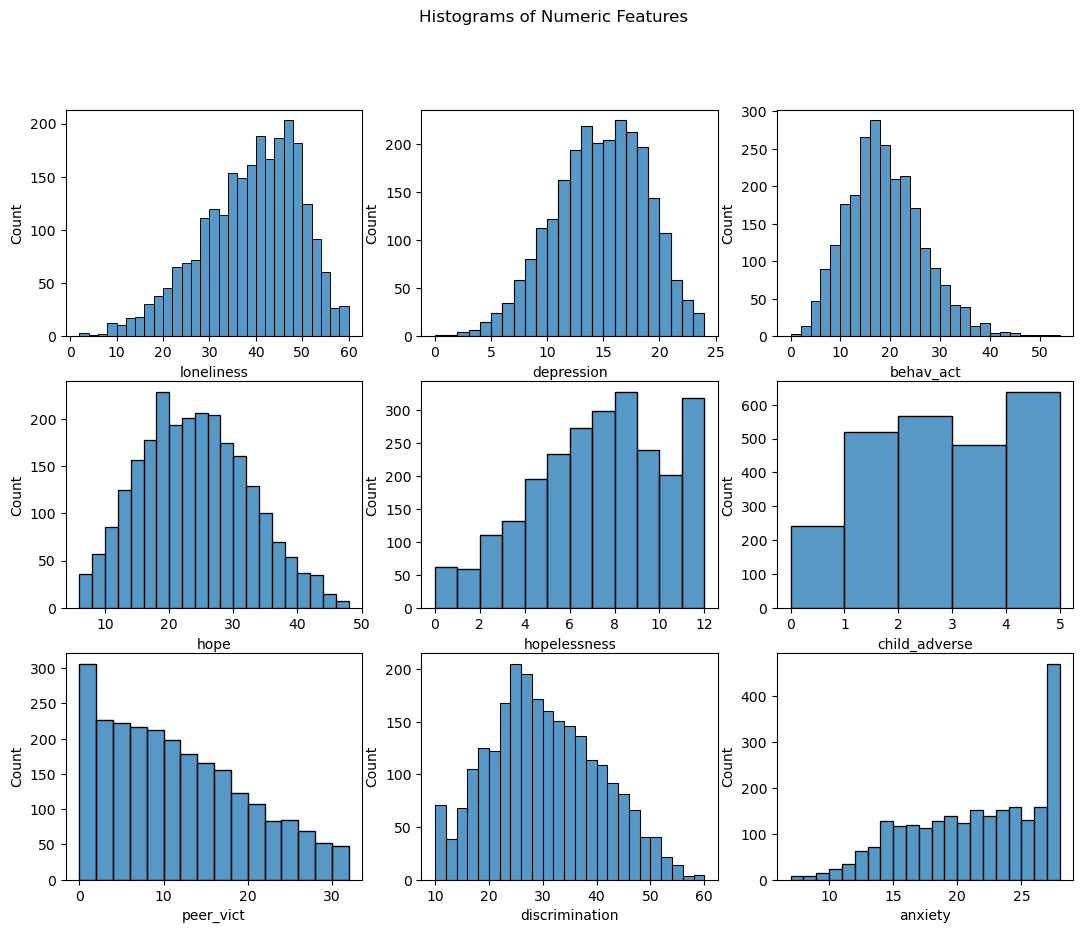

In [20]:
# histograms of numeric features
fig, axes = plt.subplots(3, 3, figsize=(13, 10))
fig.suptitle('Histograms of Numeric Features')

sns.histplot(ax=axes[0, 0], data=data['loneliness'], binwidth=2)
sns.histplot(ax=axes[0, 1], data=data['depression'], binwidth=1)
sns.histplot(ax=axes[0, 2], data=data['behav_act'], binwidth=2)
sns.histplot(ax=axes[1, 0], data=data['hope'], binwidth=2)
sns.histplot(ax=axes[1, 1], data=data['hopelessness'], binwidth=1)
sns.histplot(ax=axes[1, 2], data=data['child_adverse'], binwidth=1)
sns.histplot(ax=axes[2, 0], data=data['peer_vict'], binwidth=2)
sns.histplot(ax=axes[2, 1], data=data['discrimination'], binwidth=2)
sns.histplot(ax=axes[2, 2], data=data['anxiety'], binwidth=1)

# don't show unnecessary output about object
None

In [21]:
# examine correlations between numeric features
numeric_features = ['loneliness', 'depression', 'behav_act', 'hope', 'hopelessness', 
                    'child_adverse', 'peer_vict', 'discrimination', 'anxiety']
data[numeric_features].corr()

,loneliness,depression,behav_act,hope,hopelessness,child_adverse,peer_vict,discrimination,anxiety
loneliness,1.000000,0.550011,-0.478647,-0.423158,0.508124,0.225473,0.272284,0.347911,0.380203
depression,0.550011,1.000000,-0.643446,-0.563095,0.634688,0.302187,0.322832,0.433894,0.564212
behav_act,-0.478647,-0.643446,1.000000,0.580059,-0.531347,-0.283846,-0.244080,-0.334728,-0.440418
hope,-0.423158,-0.563095,0.580059,1.000000,-0.594862,-0.189588,-0.175221,-0.238655,-0.274598
hopelessness,0.508124,0.634688,-0.531347,-0.594862,1.000000,0.172272,0.268169,0.340686,0.415289
child_adverse,0.225473,0.302187,-0.283846,-0.189588,0.172272,1.000000,0.263421,0.341760,0.268789
peer_vict,0.272284,0.322832,-0.244080,-0.175221,0.268169,0.263421,1.000000,0.625618,0.342707
discrimination,0.347911,0.433894,-0.334728,-0.238655,0.340686,0.341760,0.625618,1.000000,0.421275
anxiety,0.380203,0.564212,-0.440418,-0.274598,0.415289,0.268789,0.342707,0.421275,1.000000


<AxesSubplot:>

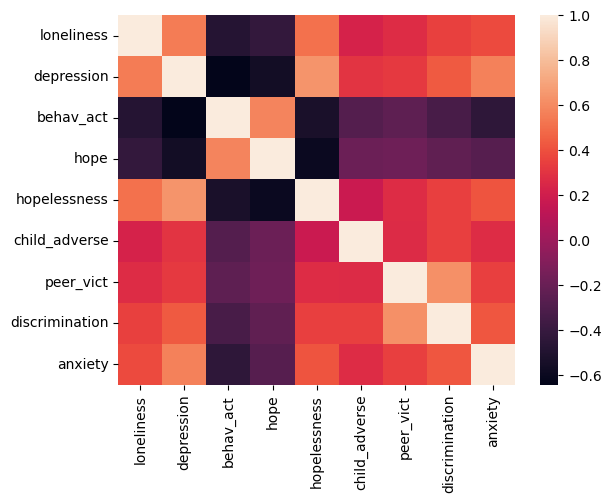

In [22]:
# visualize correlations
sns.heatmap(data[numeric_features].corr())

We can see some expected relationships.   
Strong correlations between loneliness, hopelessness, depression, and anxiety  
These tend to be inversely related to behavioral activation and hope.  
Also strong correlation between discrimination and peer victimization  
In general, a lot of correlation among predictors

### Features: categorical

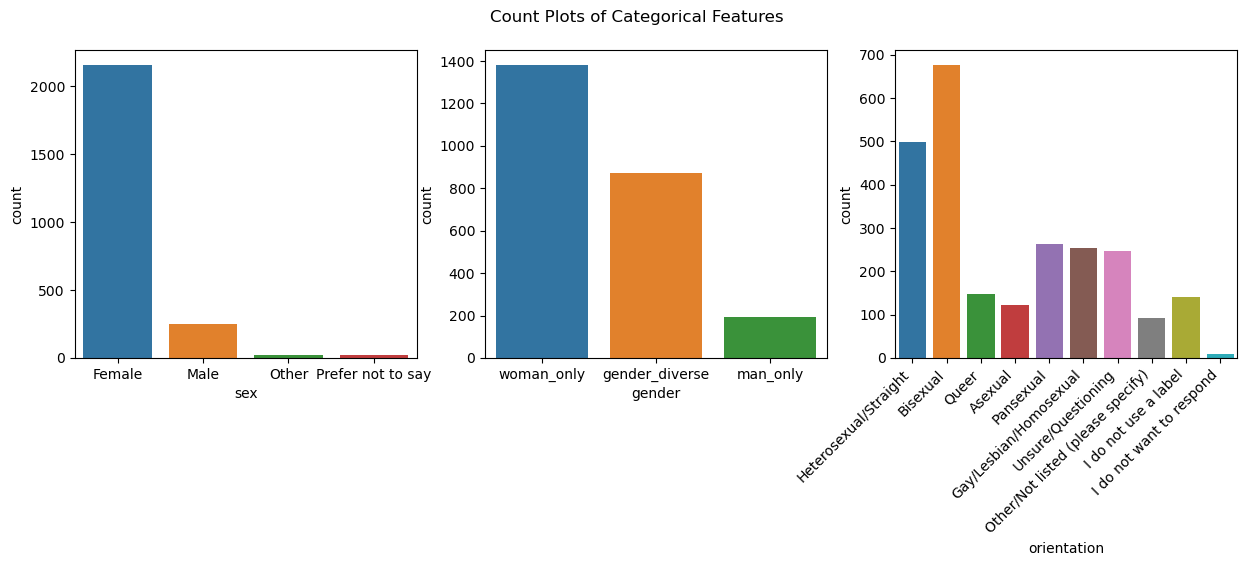

In [23]:
# count plots of categorical features
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Count Plots of Categorical Features')

sns.countplot(ax=axes[0], x=data['sex'])

sns.countplot(ax=axes[1], x=data['gender'])

sns.countplot(ax=axes[2], x=data['orientation'])

plt.xticks(rotation=45, horizontalalignment='right')
None

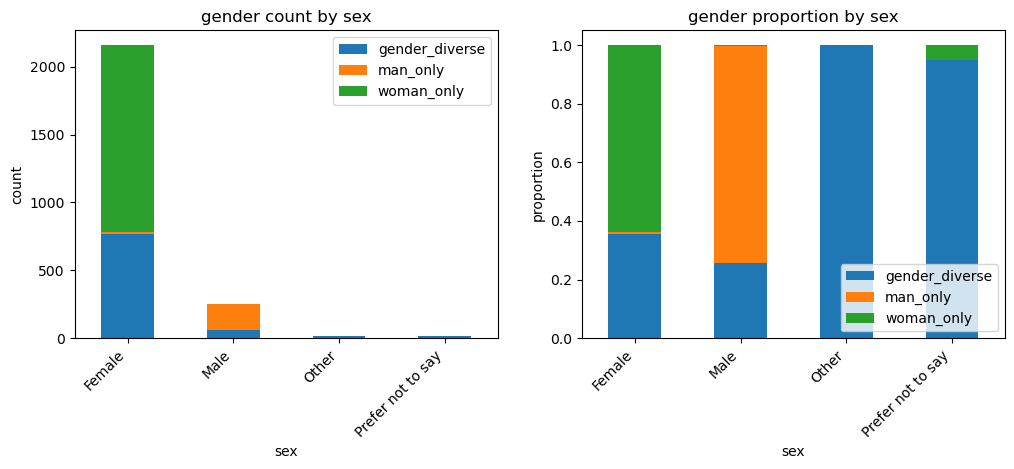

In [24]:
# examining distribution of gender by sex
cross_tab_sex_gender = pd.crosstab(index=data['sex'], columns=data['gender'])
cross_tab_sex_gender_norm = pd.crosstab(index=data['sex'], columns=data['gender'], normalize="index")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cross_tab_sex_gender.plot(ax=axes[0], kind='bar', stacked=True)
axes[0].legend(loc="upper right", ncol=1)
axes[0].set_xlabel("sex")
axes[0].set_ylabel("count")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_title("gender count by sex")

cross_tab_sex_gender_norm.plot(ax=axes[1], kind='bar', stacked=True)
axes[1].legend(loc="lower right", ncol=1)
axes[1].set_xlabel("sex")
axes[1].set_ylabel("proportion")
axes[1].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[1].set_title("gender proportion by sex")

None

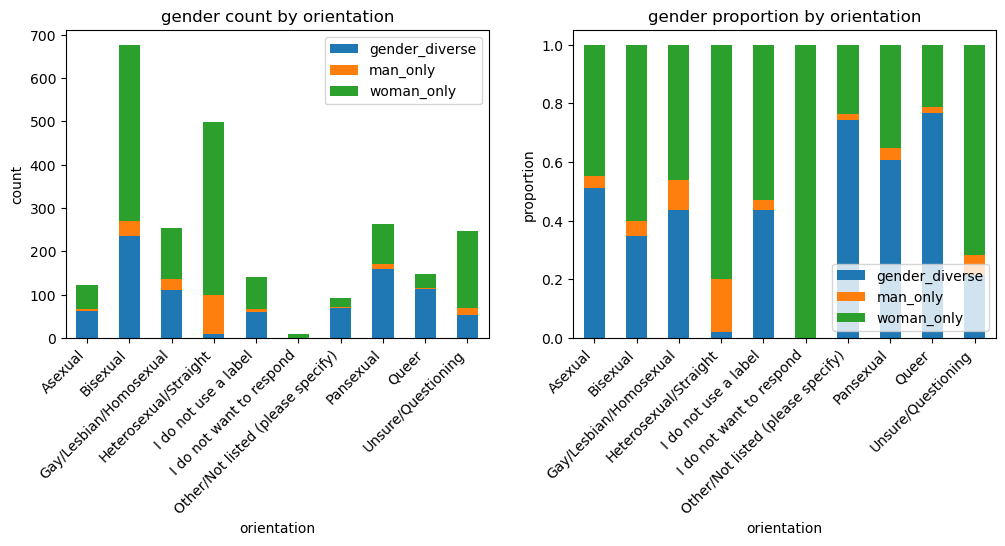

In [25]:
# examining distribution of gender by orientation
cross_tab_orient_gender = pd.crosstab(index=data['orientation'], columns=data['gender'])
cross_tab_orient_gender_norm = pd.crosstab(index=data['orientation'], columns=data['gender'], normalize="index")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cross_tab_orient_gender.plot(ax=axes[0], kind='bar', stacked=True)
axes[0].legend(loc="upper right", ncol=1)
axes[0].set_xlabel("orientation")
axes[0].set_ylabel("count")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_title("gender count by orientation")

cross_tab_orient_gender_norm.plot(ax=axes[1], kind='bar', stacked=True)
axes[1].legend(loc="lower right", ncol=1)
axes[1].set_xlabel("orientation")
axes[1].set_ylabel("proportion")
axes[1].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[1].set_title("gender proportion by orientation")

None

### Targets: numeric

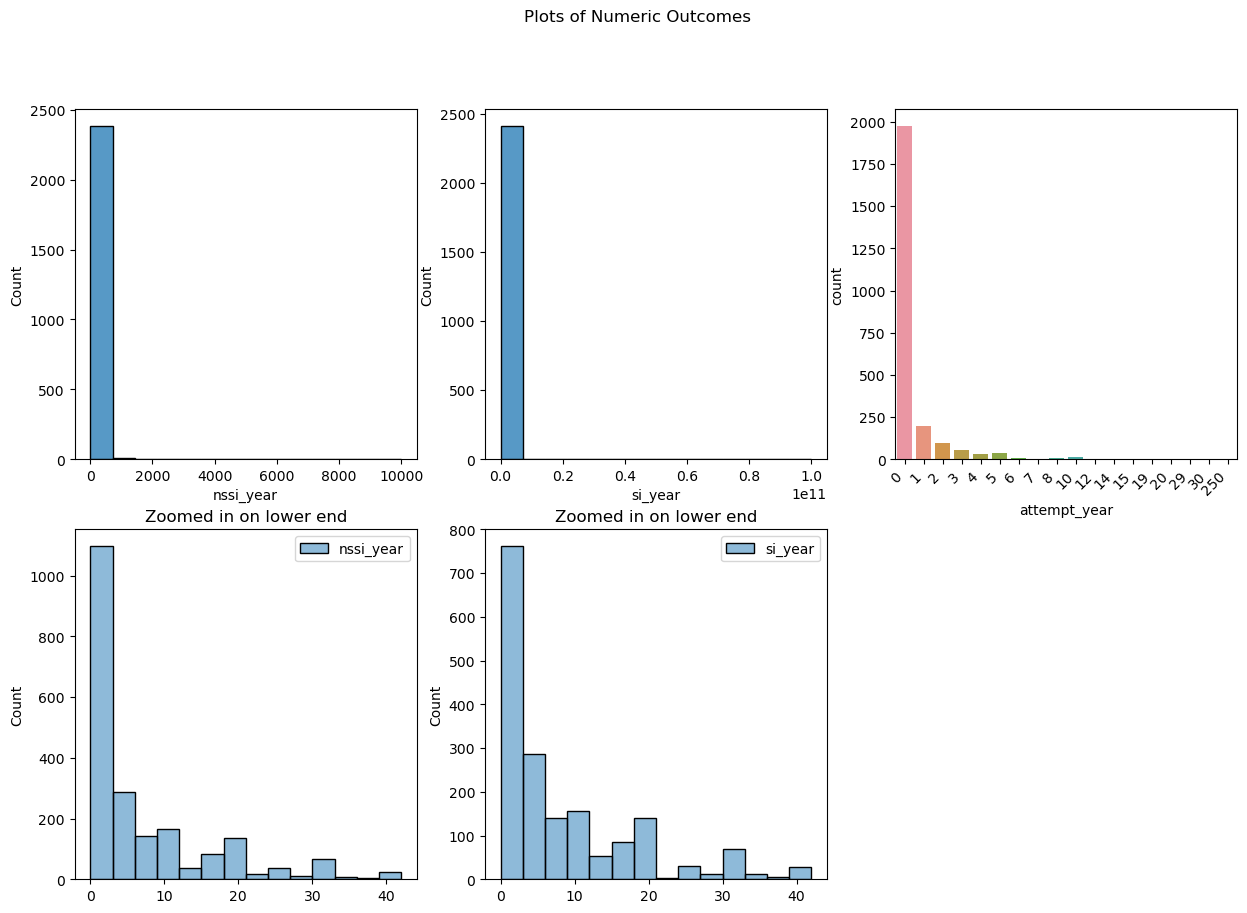

In [26]:
# plots of numeric targets
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Plots of Numeric Outcomes')

sns.histplot(ax=axes[0, 0], data=data['nssi_year'], bins=14)

sns.histplot(ax=axes[0, 1], data=data['si_year'], bins=14)

sns.countplot(ax=axes[0, 2], x=data.loc[data['attempt_year'].notna(), 'attempt_year'].astype('int'))
plt.sca(axes[0, 2])
plt.xticks(rotation=45, horizontalalignment='right')

sns.histplot(ax=axes[1, 0], data=data.loc[data['nssi_year'] < 43, ['nssi_year']], bins=14)
axes[1, 0].set_title("Zoomed in on lower end")

sns.histplot(ax=axes[1, 1], data=data.loc[data['si_year'] < 43, ['si_year']], bins=14)
axes[1, 1].set_title("Zoomed in on lower end")

fig.delaxes(axes[1, 2])

None

In [27]:
# examine correlations between outcome variables
data[['nssi_year', 'si_year', 'attempt_year']].corr()

,nssi_year,si_year,attempt_year
nssi_year,1.000000,0.049948,0.068214
si_year,0.049948,1.000000,0.012383
attempt_year,0.068214,0.012383,1.000000


<AxesSubplot:>

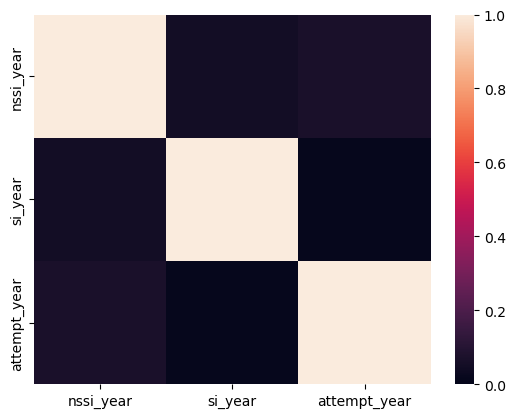

In [28]:
# visualize correlations
sns.heatmap(data[['nssi_year', 'si_year', 'attempt_year']].corr(), vmin=0, vmax=1)
None

Suprisingly little correlation between numeric outcome variables?

In [29]:
# limit some extremely large response values for outcome year variables
# to avoid issues related to extreme outliers and/or unrealistic values

# for nssi, 1000 would correspond roughly to average of 3 per day
data.loc[data['nssi_year'] > 1000, 'nssi_year'] = 1000

# same for si
data.loc[data['si_year'] > 1000, 'si_year'] = 1000

# for attempt, only one value greater than 30, will cap at 50
data.loc[data['attempt_year'] > 30, 'attempt_year'] = 50

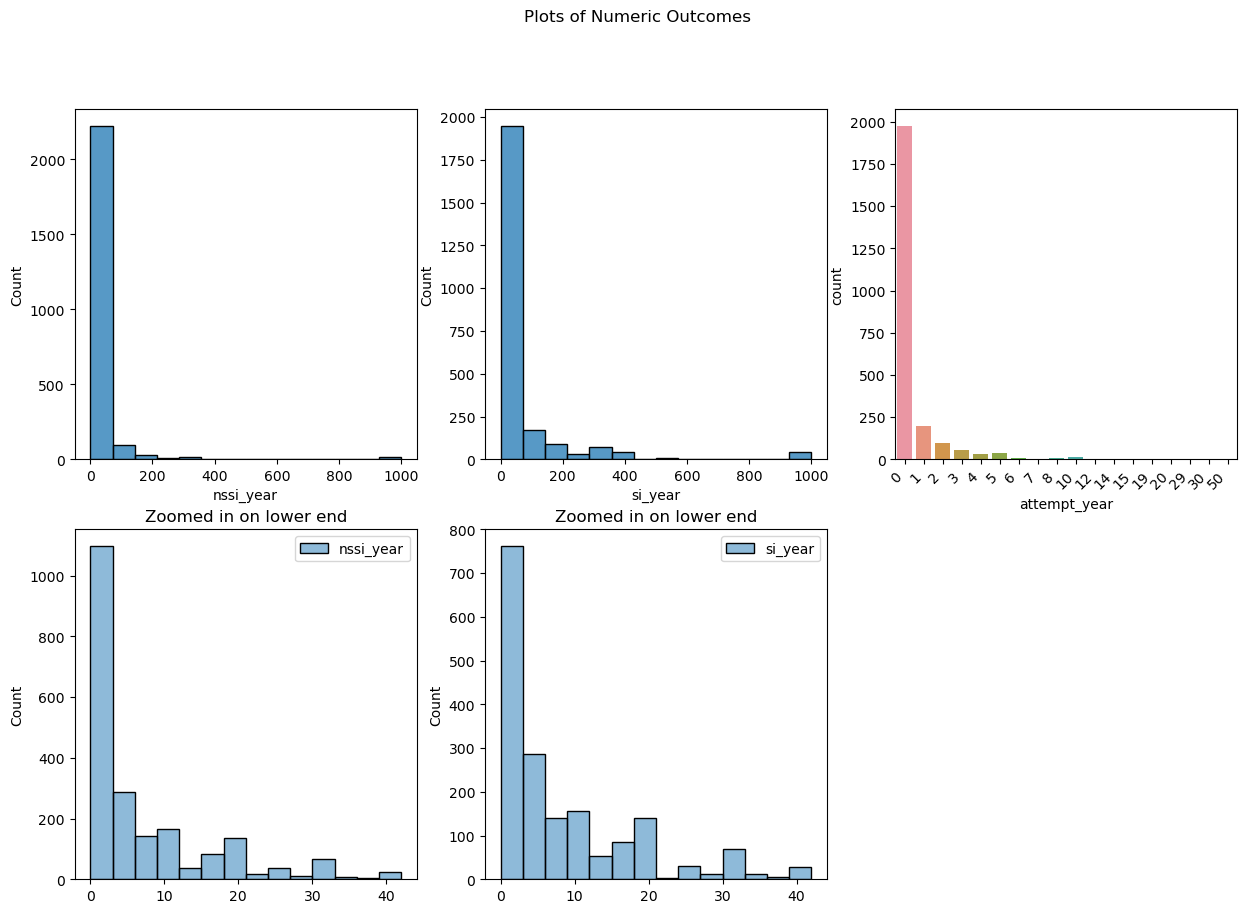

In [30]:
# redo plots and correations of outcomes after constraining outliers
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Plots of Numeric Outcomes')

sns.histplot(ax=axes[0, 0], data=data['nssi_year'], bins=14)

sns.histplot(ax=axes[0, 1], data=data['si_year'], bins=14)

sns.countplot(ax=axes[0, 2], x=data.loc[data['attempt_year'].notna(), 'attempt_year'].astype('int'))
plt.sca(axes[0, 2])
plt.xticks(rotation=45, horizontalalignment='right')

sns.histplot(ax=axes[1, 0], data=data.loc[data['nssi_year'] < 43, ['nssi_year']], bins=14)
axes[1, 0].set_title("Zoomed in on lower end")

sns.histplot(ax=axes[1, 1], data=data.loc[data['si_year'] < 43, ['si_year']], bins=14)
axes[1, 1].set_title("Zoomed in on lower end")

fig.delaxes(axes[1, 2])

None

In [31]:
data[['nssi_year', 'si_year', 'attempt_year']].corr()

,nssi_year,si_year,attempt_year
nssi_year,1.000000,0.313511,0.165091
si_year,0.313511,1.000000,0.229054
attempt_year,0.165091,0.229054,1.000000


<AxesSubplot:>

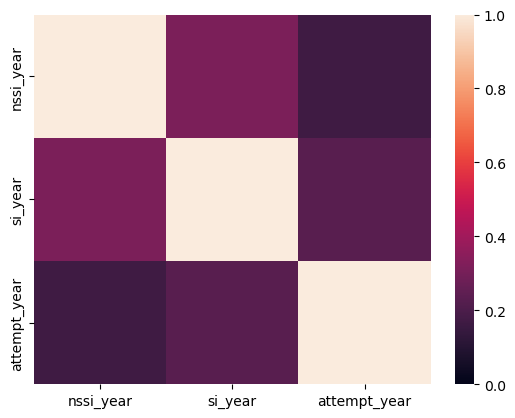

In [32]:
sns.heatmap(data[['nssi_year', 'si_year', 'attempt_year']].corr(), vmin=0, vmax=1)
None

Constraining outliers did increase correlations, but they are still small-to-moderate.

### Targets: categorical

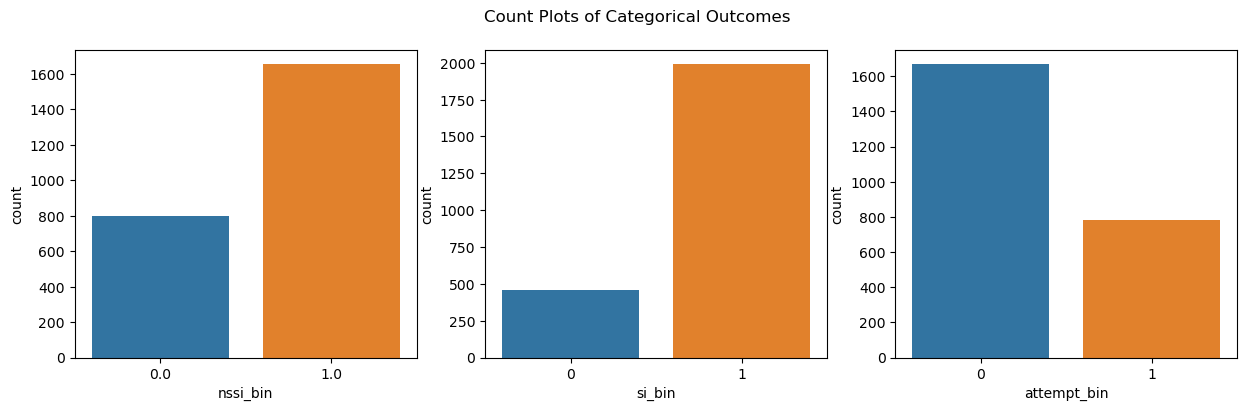

In [33]:
# count plots of categorical target variables

# count plots of categorical features
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Count Plots of Categorical Outcomes')

sns.countplot(ax=axes[0], x=data['nssi_bin'])

sns.countplot(ax=axes[1], x=data['si_bin'])

sns.countplot(ax=axes[2], x=data['attempt_bin'])

None

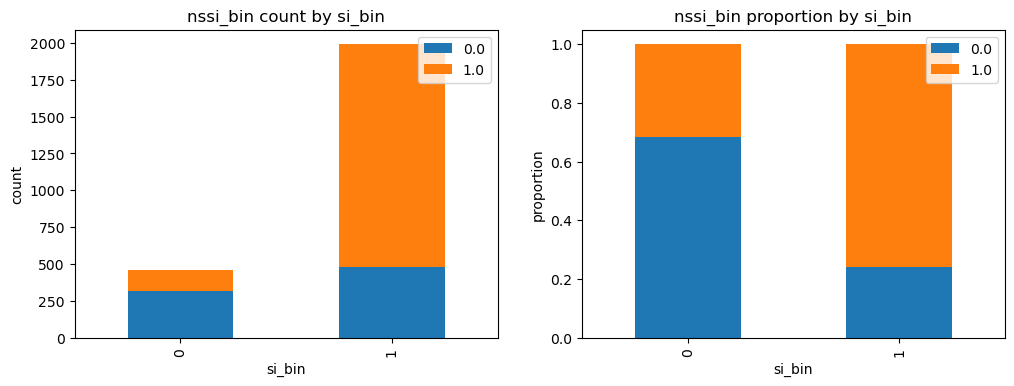

In [34]:
# examining distribution of si_bin by nssi_bin
cross_tab_si_nssi = pd.crosstab(index=data['si_bin'], columns=data['nssi_bin'])
cross_tab_si_nssi_norm = pd.crosstab(index=data['si_bin'], columns=data['nssi_bin'], normalize="index")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cross_tab_si_nssi.plot(ax=axes[0], kind='bar', stacked=True)
axes[0].legend(loc="upper right", ncol=1)
axes[0].set_xlabel("si_bin")
axes[0].set_ylabel("count")
axes[0].set_title("nssi_bin count by si_bin")

cross_tab_si_nssi_norm.plot(ax=axes[1], kind='bar', stacked=True)
axes[1].legend(loc="upper right", ncol=1)
axes[1].set_xlabel("si_bin")
axes[1].set_ylabel("proportion")
axes[1].set_title("nssi_bin proportion by si_bin")

None

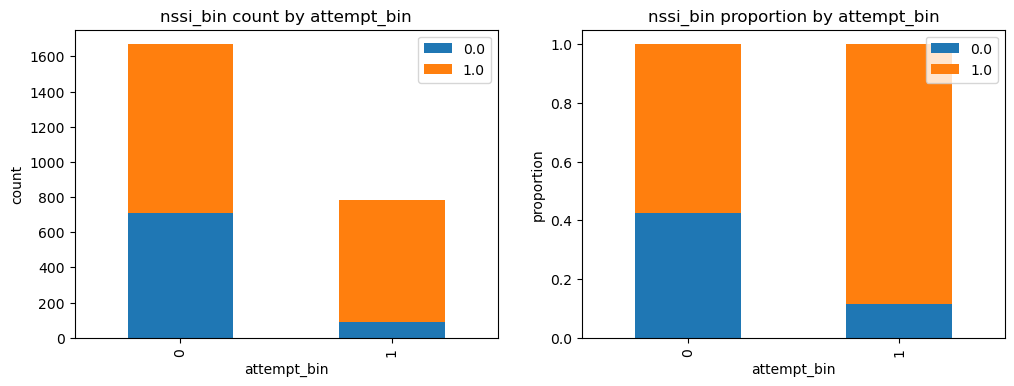

In [35]:
# examining distribution of attempt_bin by nssi_bin
cross_tab_attempt_nssi = pd.crosstab(index=data['attempt_bin'], columns=data['nssi_bin'])
cross_tab_attempt_nssi_norm = pd.crosstab(index=data['attempt_bin'], columns=data['nssi_bin'], normalize="index")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cross_tab_attempt_nssi.plot(ax=axes[0], kind='bar', stacked=True)
axes[0].legend(loc="upper right", ncol=1)
axes[0].set_xlabel("attempt_bin")
axes[0].set_ylabel("count")
axes[0].set_title("nssi_bin count by attempt_bin")

cross_tab_attempt_nssi_norm.plot(ax=axes[1], kind='bar', stacked=True)
axes[1].legend(loc="upper right", ncol=1)
axes[1].set_xlabel("attempt_bin")
axes[1].set_ylabel("proportion")
axes[1].set_title("nssi_bin proportion by attempt_bin")

None

In [36]:
# save final dataframe to csv to bypass this preprocessing in the future 
data.to_csv('data_preproc.csv', index=False)

# Hypothesis 1

## nssi_bin

In [36]:
# define target
target = data['nssi_bin']

# define features
features = data[['loneliness', 'depression', 'sex', 'gender', 'orientation', 'behav_act',
                   'hope', 'hopelessness', 'child_adverse', 'peer_vict', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)

### Dummy baseline model

In [37]:
# always predict most frequent target class
dummy_results = cross_validate(DummyClassifier(), features, target, 
                               scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)
print('The mean accuracy with cross-validation is: ' 
      f'{dummy_results["test_accuracy"].mean():.3f} +/- {dummy_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{dummy_results["test_precision"].mean():.3f} +/- {dummy_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{dummy_results["test_recall"].mean():.3f} +/- {dummy_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{dummy_results["test_roc_auc"].mean():.3f} +/- {dummy_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.674 +/- 0.002
The mean precision with cross-validation is: 0.674 +/- 0.002
The mean recall with cross-validation is: 1.000 +/- 0.000
The mean AUROC with cross-validation is: 0.500 +/- 0.000


### Logistic regression model

In [38]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [39]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, logreg)

In [40]:
# hyperparameter tuning
# hyperparameter values to try
param_grid =  {
    'logisticregression__C': [0.1, 0.5, 1, 2, 5, 10]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, return_estimator=True)

In [41]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'logisticregression__C': 0.1}
with accuracy of 0.759
Best hyperparameters for split #2:
{'logisticregression__C': 0.1}
with accuracy of 0.743
Best hyperparameters for split #3:
{'logisticregression__C': 0.1}
with accuracy of 0.744
Best hyperparameters for split #4:
{'logisticregression__C': 0.1}
with accuracy of 0.750
Best hyperparameters for split #5:
{'logisticregression__C': 0.1}
with accuracy of 0.766


0.1 appears best for C, but let's zoom in with a validation curve

In [43]:
# generate validation curve for C
C_values = [0.01, 0.1, 0.3, 0.5, 0.8, 1, 2]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='logisticregression__C', param_range=C_values, scoring='roc_auc', n_jobs=2)

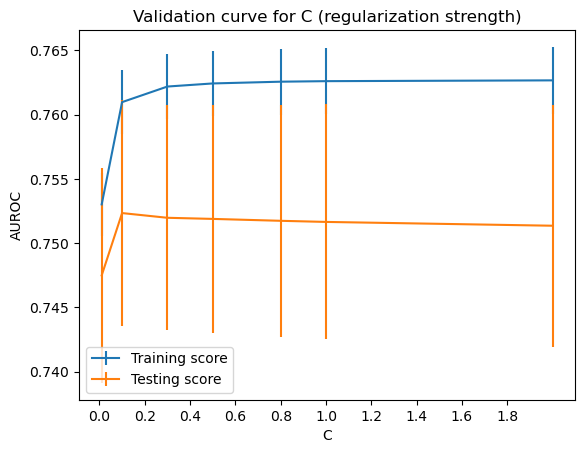

In [44]:
# plot validation curve for C
plt.errorbar(C_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(C_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 2, 0.2))
plt.xlabel("C")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for C (regularization strength)")

In [47]:
# generate validation curve for C
C_values = [0.005, 0.01, 0.03, 0.05, 0.07, 0.1, 0.15]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='logisticregression__C', param_range=C_values, scoring='roc_auc', n_jobs=2)

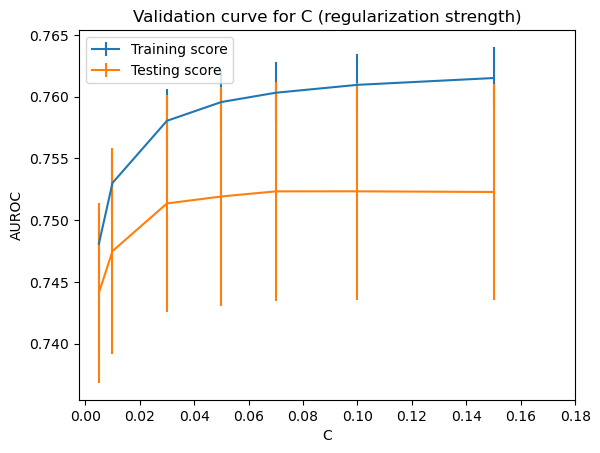

In [49]:
# plot validation curve for C
plt.errorbar(C_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(C_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 0.2, 0.02))
plt.xlabel("C")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for C (regularization strength)")

0.1 appears sufficient for C.

In [62]:
# set C to 0.1
pipeline.set_params(logisticregression__C=0.1)

# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.690 +/- 0.030
The mean precision with cross-validation is: 0.822 +/- 0.025
The mean recall with cross-validation is: 0.690 +/- 0.034
The mean AUROC with cross-validation is: 0.750 +/- 0.033


### Random forest model

In [63]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [64]:
# define algorithm
rfc = RandomForestClassifier(n_jobs=2, random_state=0, class_weight='balanced')

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, rfc)

In [67]:
# hyperparameter values to try
param_grid =  {
    'randomforestclassifier__max_leaf_nodes': [32, 64, 128, 256, 512, 1024],
    'randomforestclassifier__max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'randomforestclassifier__n_estimators': [100, 200, 300, 400, 500, 600]}

randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=500, scoring='roc_auc', n_jobs=2)

cv_results = cross_validate(randomized_search, features, target, n_jobs=2, return_estimator=True)

In [68]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__max_leaf_nodes': 128, 'randomforestclassifier__max_features': 0.1}
with accuracy of 0.726
Best hyperparameters for split #2:
{'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__max_leaf_nodes': 64, 'randomforestclassifier__max_features': 0.3}
with accuracy of 0.716
Best hyperparameters for split #3:
{'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__max_leaf_nodes': 64, 'randomforestclassifier__max_features': 0.1}
with accuracy of 0.732
Best hyperparameters for split #4:
{'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__max_leaf_nodes': 64, 'randomforestclassifier__max_features': 0.1}
with accuracy of 0.739
Best hyperparameters for split #5:
{'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_leaf_nodes': 32, 'randomforestclassifier__max_features': 0.1}
with accuracy of 0.749


200 appears sufficient for n_estimators. Let's zoom in around max_leaf_nodes of 64 and max_features of 0.1

In [77]:
pipeline.set_params(randomforestclassifier__n_estimators=200)
pipeline.set_params(randomforestclassifier__max_features=0.1)

# first generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [32, 64, 128, 256]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestclassifier__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='roc_auc', n_jobs=2)

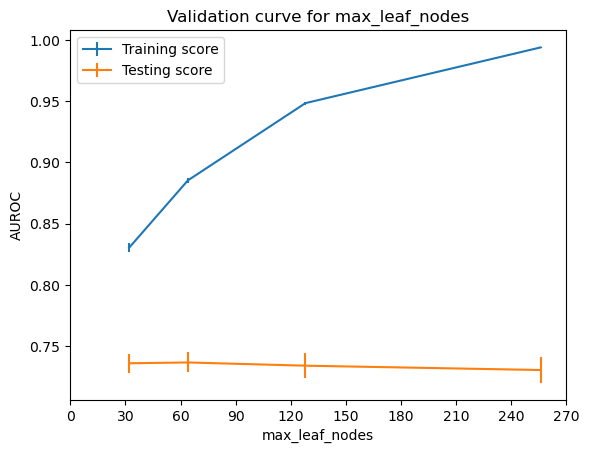

In [78]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 300, 30))
plt.xlabel("max_leaf_nodes")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for max_leaf_nodes")

In [79]:
pipeline.set_params(randomforestclassifier__max_features=0.2)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [32, 64, 128, 256]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestclassifier__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='roc_auc', n_jobs=2)

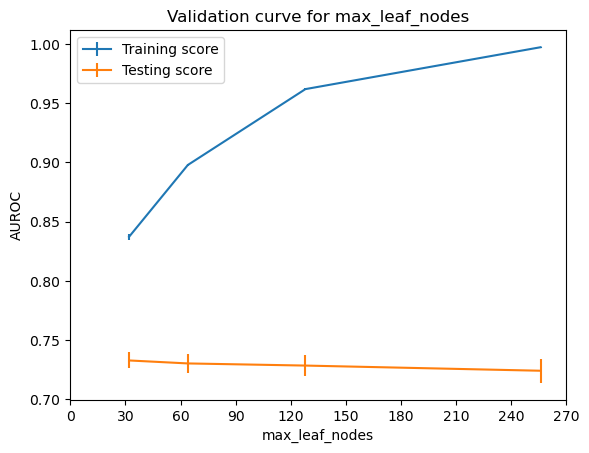

In [80]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 300, 30))
plt.xlabel("max_leaf_nodes")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for max_leaf_nodes")

In [81]:
pipeline.set_params(randomforestclassifier__max_features=0.3)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [32, 64, 128, 256]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestclassifier__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='roc_auc', n_jobs=2)

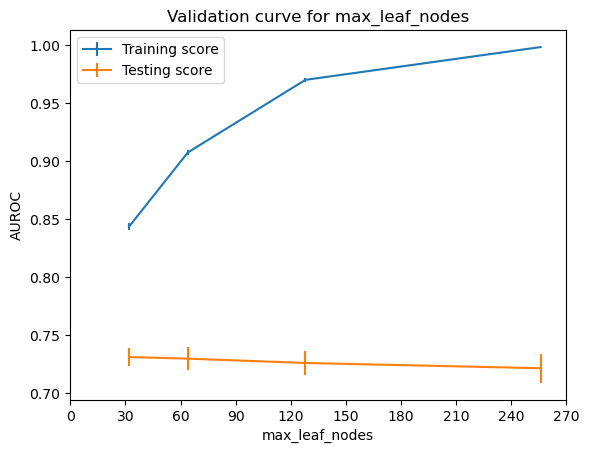

In [82]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 300, 30))
plt.xlabel("max_leaf_nodes")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for max_leaf_nodes")

max_leaf_nodes of 64 and max_features of 0.1 appears sufficient.

In [83]:
pipeline.set_params(randomforestclassifier__max_features=0.1)
pipeline.set_params(randomforestclassifier__max_leaf_nodes=64)

# get results from tuned model
rfc_results = cross_validate(pipeline, features, target, 
                             scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{rfc_results["test_accuracy"].mean():.3f} +/- {rfc_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{rfc_results["test_precision"].mean():.3f} +/- {rfc_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{rfc_results["test_recall"].mean():.3f} +/- {rfc_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{rfc_results["test_roc_auc"].mean():.3f} +/- {rfc_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.699 +/- 0.032
The mean precision with cross-validation is: 0.793 +/- 0.025
The mean recall with cross-validation is: 0.750 +/- 0.034
The mean AUROC with cross-validation is: 0.738 +/- 0.034


### Gradient boosting decision trees model

In [84]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [85]:
# hyperparameter tuning

# have to manually adjust weights to correct for class imbalance
# since HistGradientBoostingClassifier doesn't have a built-in class_weight parameter
sample_weights = compute_sample_weight(class_weight='balanced', y=target)

# define algorithm
hgbc = HistGradientBoostingClassifier(random_state=0, categorical_features=[0,1,2], learning_rate=0.1)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, hgbc)

# hyperparameter values to try
param_grid =  {
    'histgradientboostingclassifier__max_iter': [50, 100, 150, 200, 250],
    'histgradientboostingclassifier__max_leaf_nodes': [8, 16, 32, 64, 128, 256]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, 
                            fit_params={'histgradientboostingclassifier__sample_weight': sample_weights}, 
                            return_estimator=True)

In [86]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with accuracy of 0.738
Best hyperparameters for split #2:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with accuracy of 0.727
Best hyperparameters for split #3:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with accuracy of 0.725
Best hyperparameters for split #4:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with accuracy of 0.714
Best hyperparameters for split #5:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with accuracy of 0.755


Let's examine max_leaf_nodes while holding max_iter at 50.

In [88]:
pipeline.set_params(histgradientboostingclassifier__max_iter=50)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [4, 8, 12, 16, 20, 24]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='histgradientboostingclassifier__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='roc_auc', n_jobs=2)

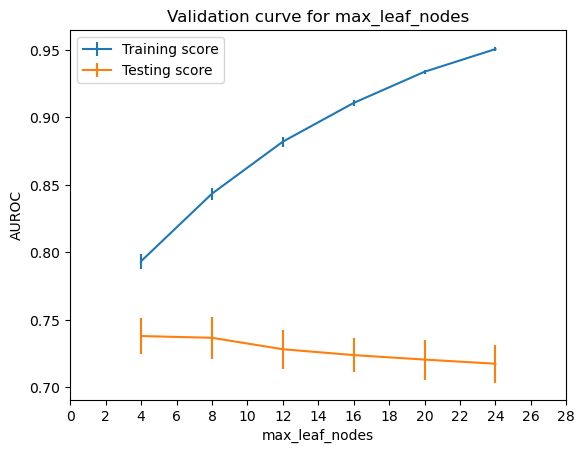

In [90]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 30, 2))
plt.xlabel("max_leaf_nodes")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for max_leaf_nodes")

max_leaf_nodes of 4 appears sufficient.

In [91]:
pipeline.set_params(histgradientboostingclassifier__max_leaf_nodes=4)

# get results from tuned model
hgbc_results = cross_validate(pipeline, features, target, 
                              scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val, 
                              fit_params={'histgradientboostingclassifier__sample_weight': sample_weights})

print('The mean accuracy with cross-validation is: ' 
      f'{hgbc_results["test_accuracy"].mean():.3f} +/- {hgbc_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{hgbc_results["test_precision"].mean():.3f} +/- {hgbc_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{hgbc_results["test_recall"].mean():.3f} +/- {hgbc_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{hgbc_results["test_roc_auc"].mean():.3f} +/- {hgbc_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.686 +/- 0.030
The mean precision with cross-validation is: 0.810 +/- 0.025
The mean recall with cross-validation is: 0.699 +/- 0.034
The mean AUROC with cross-validation is: 0.740 +/- 0.033


### Model comparison

In [94]:
print('Dummy baseline model')
print('AUROC: ' 
      f'{dummy_results["test_roc_auc"].mean():.3f} +/- {dummy_results["test_roc_auc"].std():.3f}') 
print()
print('Logistic regression model')
print('AUROC: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 
print()
print('Random forest model')
print('AUROC: ' 
      f'{rfc_results["test_roc_auc"].mean():.3f} +/- {rfc_results["test_roc_auc"].std():.3f}') 
print()
print('Gradient boosting decision trees model')
print('AUROC: ' 
      f'{hgbc_results["test_roc_auc"].mean():.3f} +/- {hgbc_results["test_roc_auc"].std():.3f}') 

Dummy baseline model
AUROC: 0.500 +/- 0.000

Logistic regression model
AUROC: 0.750 +/- 0.033

Random forest model
AUROC: 0.738 +/- 0.034

Gradient boosting decision trees model
AUROC: 0.740 +/- 0.033


((0.7103763137140116, 0.2896180303119844, 5.65597400403739e-06), <Figure size 640x480 with 1 Axes>)


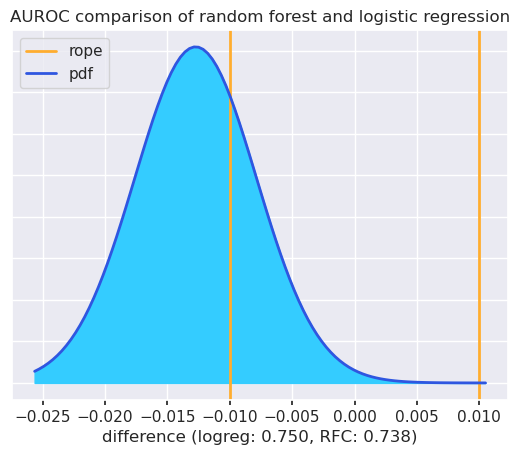

In [95]:
# statistical test comparing performance
rfc_vs_logreg = two_on_single(x=logreg_results["test_roc_auc"], y=rfc_results["test_roc_auc"], 
                                rope=0.01, runs=10, names=('logreg', 'RFC'), plot=True)
plt.title("AUROC comparison of random forest and logistic regression")
print(rfc_vs_logreg)

((0.5393425784913718, 0.4606574002183843, 2.129024390118417e-08), <Figure size 640x480 with 1 Axes>)


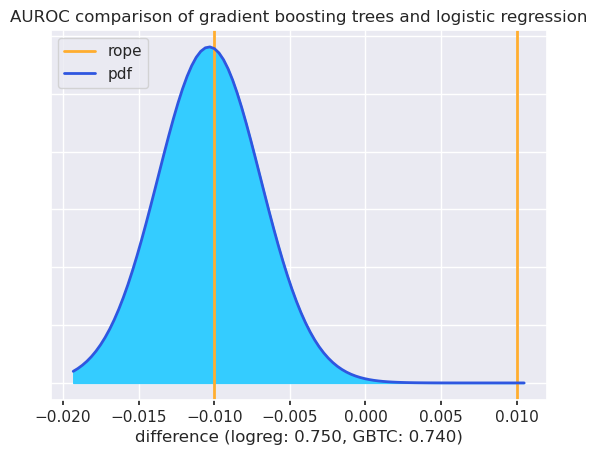

In [96]:
# statistical test comparing performance
hgbc_vs_logreg = two_on_single(x=logreg_results["test_roc_auc"], y=hgbc_results["test_roc_auc"], 
                                rope=0.01, runs=10, names=('logreg', 'GBTC'), plot=True)
plt.title("AUROC comparison of gradient boosting trees and logistic regression")
print(hgbc_vs_logreg)

## si_bin

In [3]:
# define target
target = data['si_bin']

# define features
features = data[['loneliness', 'depression', 'sex', 'gender', 'orientation', 'behav_act',
                   'hope', 'hopelessness', 'child_adverse', 'peer_vict', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)

### Dummy baseline model

In [4]:
# always predict most frequent target class
dummy_results = cross_validate(DummyClassifier(), features, target, 
                               scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)
print('The mean accuracy with cross-validation is: ' 
      f'{dummy_results["test_accuracy"].mean():.3f} +/- {dummy_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{dummy_results["test_precision"].mean():.3f} +/- {dummy_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{dummy_results["test_recall"].mean():.3f} +/- {dummy_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{dummy_results["test_roc_auc"].mean():.3f} +/- {dummy_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.812 +/- 0.001
The mean precision with cross-validation is: 0.812 +/- 0.001
The mean recall with cross-validation is: 1.000 +/- 0.000
The mean AUROC with cross-validation is: 0.500 +/- 0.000


### Logistic regression model

In [5]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [6]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, logreg)

In [7]:
# hyperparameter tuning
# hyperparameter values to try
param_grid =  {
    'logisticregression__C': [0.1, 0.5, 1, 2, 5, 10]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, return_estimator=True)

In [8]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'logisticregression__C': 0.1}
with accuracy of 0.716
Best hyperparameters for split #2:
{'logisticregression__C': 0.1}
with accuracy of 0.759
Best hyperparameters for split #3:
{'logisticregression__C': 0.1}
with accuracy of 0.782
Best hyperparameters for split #4:
{'logisticregression__C': 0.1}
with accuracy of 0.749
Best hyperparameters for split #5:
{'logisticregression__C': 0.1}
with accuracy of 0.749


0.1 appears best for C, but let's zoom in with a validation curve

In [9]:
# generate validation curve for C
C_values = [0.01, 0.1, 0.3, 0.5, 0.8, 1, 2]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='logisticregression__C', param_range=C_values, scoring='roc_auc', n_jobs=2)

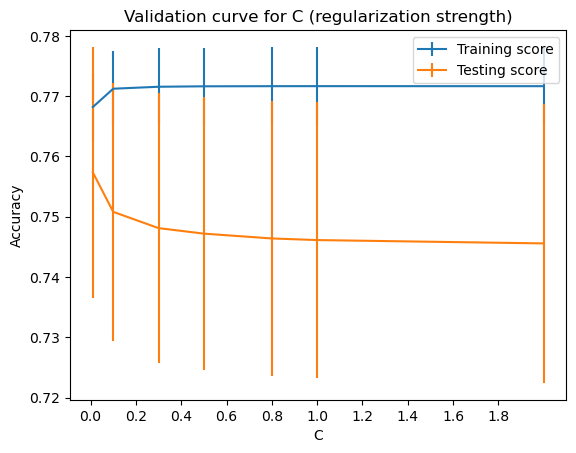

In [10]:
# plot validation curve for C
plt.errorbar(C_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(C_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 2, 0.2))
plt.xlabel("C")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for C (regularization strength)")

A value less than 0.1 for C may be better.

In [11]:
# generate validation curve for C
C_values = [0.005, 0.01, 0.03, 0.05, 0.07, 0.09]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='logisticregression__C', param_range=C_values, scoring='roc_auc', n_jobs=2)

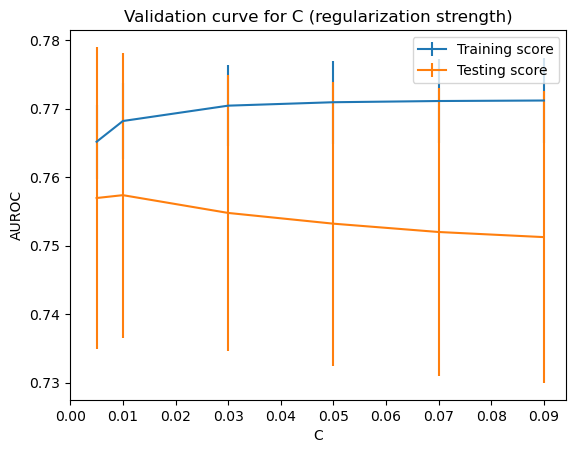

In [12]:
# plot validation curve for C
plt.errorbar(C_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(C_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 0.1, 0.01))
plt.xlabel("C")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for C (regularization strength)")

C of 0.01 appears best.

In [13]:
pipeline.set_params(logisticregression__C=0.01)

# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.707 +/- 0.026
The mean precision with cross-validation is: 0.912 +/- 0.020
The mean recall with cross-validation is: 0.708 +/- 0.030
The mean AUROC with cross-validation is: 0.759 +/- 0.040


### Random forest model

In [14]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [15]:
# define algorithm
rfc = RandomForestClassifier(n_jobs=2, random_state=0, class_weight='balanced')

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, rfc)

In [16]:
# hyperparameter values to try
param_grid =  {
    'randomforestclassifier__max_leaf_nodes': [32, 64, 128, 256, 512, 1024],
    'randomforestclassifier__max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'randomforestclassifier__n_estimators': [100, 200, 300, 400, 500, 600]}

randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=500, scoring='roc_auc', n_jobs=2)

cv_results = cross_validate(randomized_search, features, target, n_jobs=2, return_estimator=True)

In [17]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__max_leaf_nodes': 64, 'randomforestclassifier__max_features': 0.3}
with accuracy of 0.705
Best hyperparameters for split #2:
{'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_leaf_nodes': 32, 'randomforestclassifier__max_features': 0.3}
with accuracy of 0.751
Best hyperparameters for split #3:
{'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__max_leaf_nodes': 64, 'randomforestclassifier__max_features': 0.2}
with accuracy of 0.810
Best hyperparameters for split #4:
{'randomforestclassifier__n_estimators': 400, 'randomforestclassifier__max_leaf_nodes': 128, 'randomforestclassifier__max_features': 0.3}
with accuracy of 0.749
Best hyperparameters for split #5:
{'randomforestclassifier__n_estimators': 300, 'randomforestclassifier__max_leaf_nodes': 128, 'randomforestclassifier__max_features': 0.3}
with accuracy of 0.795


We'll try a more focused search around these results.

In [18]:
pipeline.set_params(randomforestclassifier__n_estimators=200)

param_grid =  {
    'randomforestclassifier__max_leaf_nodes': [32, 64, 128],
    'randomforestclassifier__max_features': [0.1, 0.2, 0.3, 0.4]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, return_estimator=True)

In [19]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'randomforestclassifier__max_features': 0.3, 'randomforestclassifier__max_leaf_nodes': 128}
with accuracy of 0.713
Best hyperparameters for split #2:
{'randomforestclassifier__max_features': 0.1, 'randomforestclassifier__max_leaf_nodes': 64}
with accuracy of 0.755
Best hyperparameters for split #3:
{'randomforestclassifier__max_features': 0.1, 'randomforestclassifier__max_leaf_nodes': 64}
with accuracy of 0.811
Best hyperparameters for split #4:
{'randomforestclassifier__max_features': 0.3, 'randomforestclassifier__max_leaf_nodes': 128}
with accuracy of 0.752
Best hyperparameters for split #5:
{'randomforestclassifier__max_features': 0.2, 'randomforestclassifier__max_leaf_nodes': 64}
with accuracy of 0.798


In [20]:
pipeline.set_params(randomforestclassifier__max_leaf_nodes=64)

param_grid =  {
    'randomforestclassifier__n_estimators': [100, 200, 300, 400],
    'randomforestclassifier__max_features': [0.1, 0.2, 0.3, 0.4]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, return_estimator=True)

In [21]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'randomforestclassifier__max_features': 0.3, 'randomforestclassifier__n_estimators': 300}
with accuracy of 0.705
Best hyperparameters for split #2:
{'randomforestclassifier__max_features': 0.1, 'randomforestclassifier__n_estimators': 400}
with accuracy of 0.754
Best hyperparameters for split #3:
{'randomforestclassifier__max_features': 0.2, 'randomforestclassifier__n_estimators': 100}
with accuracy of 0.810
Best hyperparameters for split #4:
{'randomforestclassifier__max_features': 0.4, 'randomforestclassifier__n_estimators': 300}
with accuracy of 0.745
Best hyperparameters for split #5:
{'randomforestclassifier__max_features': 0.3, 'randomforestclassifier__n_estimators': 300}
with accuracy of 0.795


In [22]:
pipeline.set_params(randomforestclassifier__max_features=0.2)

# generate validation curve for n_estimators
n_estimators_values = [100, 200, 300, 400]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestclassifier__n_estimators', 
    param_range=n_estimators_values, scoring='roc_auc', n_jobs=2)

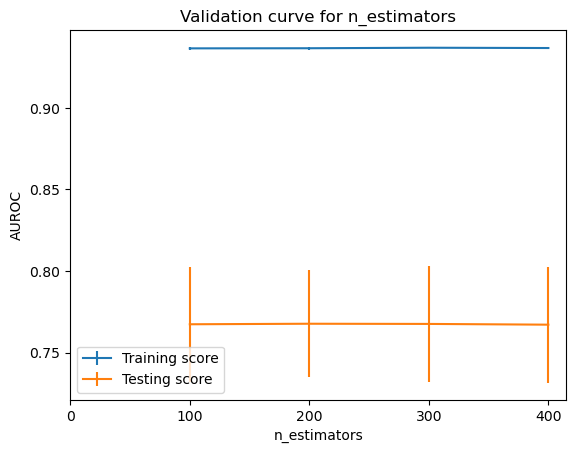

In [23]:
# plot validation curve for n_estimators
plt.errorbar(n_estimators_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(n_estimators_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 500, 100))
plt.xlabel("n_estimators")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for n_estimators")

In [24]:
pipeline.set_params(randomforestclassifier__n_estimators=100)

# generate validation curve for max_features
max_features_values = [0.1, 0.2, 0.3, 0.4]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestclassifier__max_features', 
    param_range=max_features_values, scoring='roc_auc', n_jobs=2)

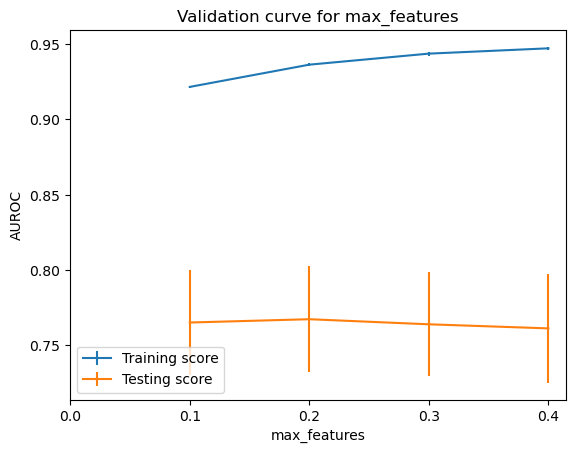

In [25]:
# plot validation curve for max_features
plt.errorbar(max_features_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_features_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 0.5, 0.1))
plt.xlabel("max_features")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for max_features")

We will proceed with max_leaf_nodes of 64, n_estimators of 100, and max_features of 0.2.

In [26]:
pipeline.set_params(randomforestclassifier__max_features=0.2)
pipeline.set_params(randomforestclassifier__max_leaf_nodes=64)
pipeline.set_params(randomforestclassifier__n_estimators=100)

# get results from tuned model
rfc_results = cross_validate(pipeline, features, target, 
                             scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{rfc_results["test_accuracy"].mean():.3f} +/- {rfc_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{rfc_results["test_precision"].mean():.3f} +/- {rfc_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{rfc_results["test_recall"].mean():.3f} +/- {rfc_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{rfc_results["test_roc_auc"].mean():.3f} +/- {rfc_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.783 +/- 0.023
The mean precision with cross-validation is: 0.887 +/- 0.017
The mean recall with cross-validation is: 0.840 +/- 0.028
The mean AUROC with cross-validation is: 0.766 +/- 0.040


### Gradient boosting decision trees model

In [27]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [28]:
# hyperparameter tuning

# have to manually adjust weights to correct for class imbalance
# since HistGradientBoostingClassifier doesn't have a built-in class_weight parameter
sample_weights = compute_sample_weight(class_weight='balanced', y=target)

# define algorithm
hgbc = HistGradientBoostingClassifier(random_state=0, categorical_features=[0,1,2], learning_rate=0.1)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, hgbc)

# hyperparameter values to try
param_grid =  {
    'histgradientboostingclassifier__max_iter': [50, 100, 150, 200, 250],
    'histgradientboostingclassifier__max_leaf_nodes': [8, 16, 32, 64, 128, 256]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, 
                            fit_params={'histgradientboostingclassifier__sample_weight': sample_weights}, 
                            return_estimator=True)

In [29]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with accuracy of 0.719
Best hyperparameters for split #2:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with accuracy of 0.767
Best hyperparameters for split #3:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with accuracy of 0.806
Best hyperparameters for split #4:
{'histgradientboostingclassifier__max_iter': 150, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with accuracy of 0.739
Best hyperparameters for split #5:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with accuracy of 0.759


Let's examine max_leaf_nodes while holding max_iter at 50.

In [30]:
pipeline.set_params(histgradientboostingclassifier__max_iter=50)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [4, 8, 12, 16, 20, 24]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='histgradientboostingclassifier__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='roc_auc', n_jobs=2)

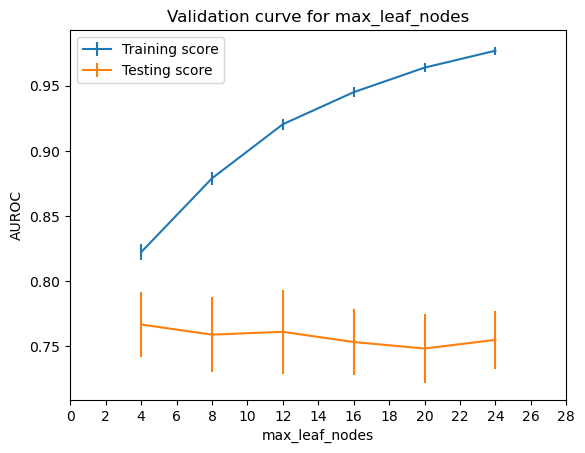

In [31]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 30, 2))
plt.xlabel("max_leaf_nodes")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for max_leaf_nodes")

max_leaf_nodes of 4 appears sufficient.

In [32]:
pipeline.set_params(histgradientboostingclassifier__max_leaf_nodes=4)

# get results from tuned model
hgbc_results = cross_validate(pipeline, features, target, 
                              scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val, 
                              fit_params={'histgradientboostingclassifier__sample_weight': sample_weights})

print('The mean accuracy with cross-validation is: ' 
      f'{hgbc_results["test_accuracy"].mean():.3f} +/- {hgbc_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{hgbc_results["test_precision"].mean():.3f} +/- {hgbc_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{hgbc_results["test_recall"].mean():.3f} +/- {hgbc_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{hgbc_results["test_roc_auc"].mean():.3f} +/- {hgbc_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.730 +/- 0.024
The mean precision with cross-validation is: 0.906 +/- 0.019
The mean recall with cross-validation is: 0.746 +/- 0.030
The mean AUROC with cross-validation is: 0.768 +/- 0.037


### Model comparison

In [33]:
print('Dummy baseline model')
print('AUROC: ' 
      f'{dummy_results["test_roc_auc"].mean():.3f} +/- {dummy_results["test_roc_auc"].std():.3f}') 
print()
print('Logistic regression model')
print('AUROC: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 
print()
print('Random forest model')
print('AUROC: ' 
      f'{rfc_results["test_roc_auc"].mean():.3f} +/- {rfc_results["test_roc_auc"].std():.3f}') 
print()
print('Gradient boosting decision trees model')
print('AUROC: ' 
      f'{hgbc_results["test_roc_auc"].mean():.3f} +/- {hgbc_results["test_roc_auc"].std():.3f}') 

Dummy baseline model
AUROC: 0.500 +/- 0.000

Logistic regression model
AUROC: 0.759 +/- 0.040

Random forest model
AUROC: 0.766 +/- 0.040

Gradient boosting decision trees model
AUROC: 0.768 +/- 0.037


((0.0019857410330105436, 0.7083575491607347, 0.2896567098062548), <Figure size 640x480 with 1 Axes>)


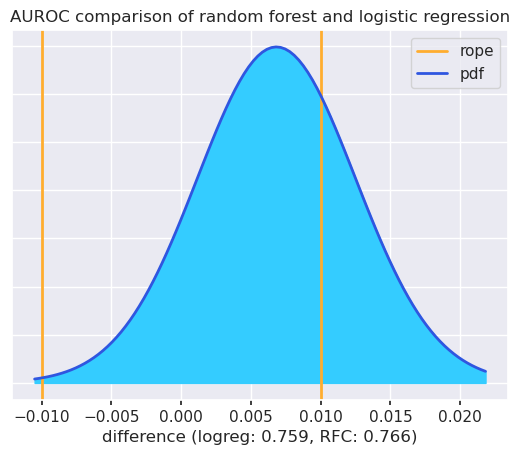

In [34]:
# statistical test comparing performance
rfc_vs_logreg = two_on_single(x=logreg_results["test_roc_auc"], y=rfc_results["test_roc_auc"], 
                                rope=0.01, runs=10, names=('logreg', 'RFC'), plot=True)
plt.title("AUROC comparison of random forest and logistic regression")
print(rfc_vs_logreg)

((0.001616869642323951, 0.5966548474983351, 0.4017282828593409), <Figure size 640x480 with 1 Axes>)


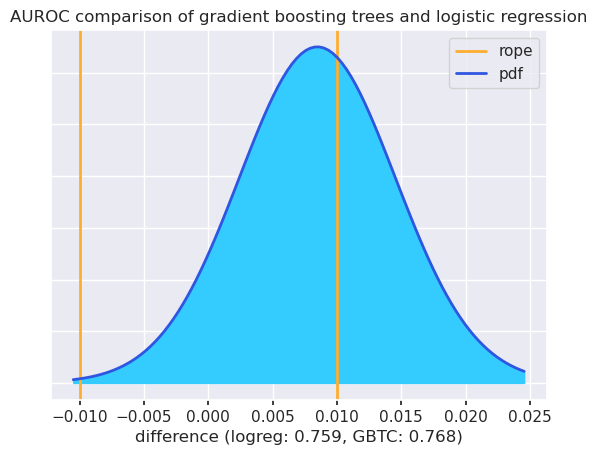

In [35]:
# statistical test comparing performance
hgbc_vs_logreg = two_on_single(x=logreg_results["test_roc_auc"], y=hgbc_results["test_roc_auc"], 
                                rope=0.01, runs=10, names=('logreg', 'GBTC'), plot=True)
plt.title("AUROC comparison of gradient boosting trees and logistic regression")
print(hgbc_vs_logreg)

## attempt_bin

In [3]:
# define target
target = data['attempt_bin']

# define features
features = data[['loneliness', 'depression', 'sex', 'gender', 'orientation', 'behav_act',
                   'hope', 'hopelessness', 'child_adverse', 'peer_vict', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=0)

### Dummy baseline model

In [4]:
# always predict most frequent target class
dummy_results = cross_validate(DummyClassifier(), features, target, 
                               scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)
print('The mean accuracy with cross-validation is: ' 
      f'{dummy_results["test_accuracy"].mean():.3f} +/- {dummy_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{dummy_results["test_precision"].mean():.3f} +/- {dummy_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{dummy_results["test_recall"].mean():.3f} +/- {dummy_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{dummy_results["test_roc_auc"].mean():.3f} +/- {dummy_results["test_roc_auc"].std():.3f}') 

C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precis

The mean accuracy with cross-validation is: 0.681 +/- 0.002
The mean precision with cross-validation is: 0.000 +/- 0.000
The mean recall with cross-validation is: 0.000 +/- 0.000
The mean AUROC with cross-validation is: 0.500 +/- 0.000


C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jpowe\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precis

Warning is expected. It means precision can't really be defined 
because the positive class is never predicted (because it is the minority class in this case).

### Logistic regression model

In [6]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [7]:
# define algorithm
logreg = LogisticRegression(class_weight='balanced', random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, logreg)

In [8]:
# hyperparameter tuning
# hyperparameter values to try
param_grid =  {
    'logisticregression__C': [0.1, 0.5, 1, 2, 5, 10]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, return_estimator=True)

In [9]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'logisticregression__C': 0.1}
with accuracy of 0.738
Best hyperparameters for split #2:
{'logisticregression__C': 0.1}
with accuracy of 0.772
Best hyperparameters for split #3:
{'logisticregression__C': 0.1}
with accuracy of 0.803
Best hyperparameters for split #4:
{'logisticregression__C': 0.1}
with accuracy of 0.752
Best hyperparameters for split #5:
{'logisticregression__C': 0.1}
with accuracy of 0.737


0.1 appears best for C, but let's zoom in with a validation curve

In [10]:
# generate validation curve for C
C_values = [0.01, 0.1, 0.3, 0.5, 0.8, 1, 2]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='logisticregression__C', param_range=C_values, scoring='roc_auc', n_jobs=2)

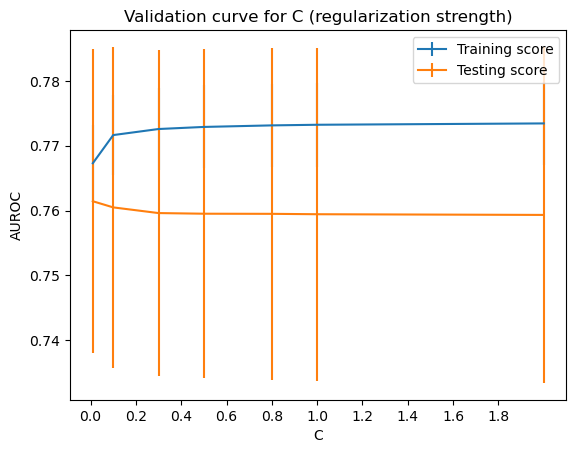

In [11]:
# plot validation curve for C
plt.errorbar(C_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(C_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 2, 0.2))
plt.xlabel("C")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for C (regularization strength)")

A value less than 0.1 for C may be better.

In [12]:
# generate validation curve for C
C_values = [0.005, 0.01, 0.03, 0.05, 0.07, 0.09]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='logisticregression__C', param_range=C_values, scoring='roc_auc', n_jobs=2)

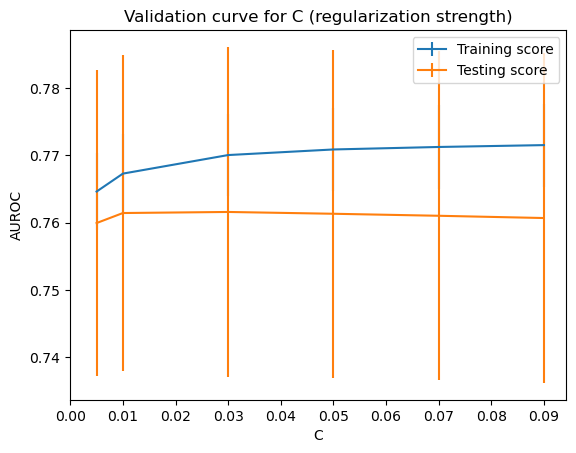

In [13]:
# plot validation curve for C
plt.errorbar(C_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(C_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 0.1, 0.01))
plt.xlabel("C")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for C (regularization strength)")

C of 0.01 appears best.

In [14]:
pipeline.set_params(logisticregression__C=0.01)

# get results from tuned model
logreg_results = cross_validate(pipeline, features, target, 
                                scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{logreg_results["test_accuracy"].mean():.3f} +/- {logreg_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{logreg_results["test_precision"].mean():.3f} +/- {logreg_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{logreg_results["test_recall"].mean():.3f} +/- {logreg_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.696 +/- 0.024
The mean precision with cross-validation is: 0.519 +/- 0.029
The mean recall with cross-validation is: 0.705 +/- 0.045
The mean AUROC with cross-validation is: 0.762 +/- 0.028


### Random forest model

In [15]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [16]:
# define algorithm
rfc = RandomForestClassifier(n_jobs=2, random_state=0, class_weight='balanced')

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, rfc)

In [17]:
# hyperparameter values to try
param_grid =  {
    'randomforestclassifier__max_leaf_nodes': [32, 64, 128, 256, 512, 1024],
    'randomforestclassifier__max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'randomforestclassifier__n_estimators': [100, 200, 300, 400, 500, 600]}

randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=500, scoring='roc_auc', n_jobs=2)

cv_results = cross_validate(randomized_search, features, target, n_jobs=2, return_estimator=True)

In [18]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'randomforestclassifier__n_estimators': 500, 'randomforestclassifier__max_leaf_nodes': 128, 'randomforestclassifier__max_features': 0.2}
with accuracy of 0.724
Best hyperparameters for split #2:
{'randomforestclassifier__n_estimators': 600, 'randomforestclassifier__max_leaf_nodes': 128, 'randomforestclassifier__max_features': 0.1}
with accuracy of 0.777
Best hyperparameters for split #3:
{'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__max_leaf_nodes': 64, 'randomforestclassifier__max_features': 0.3}
with accuracy of 0.801
Best hyperparameters for split #4:
{'randomforestclassifier__n_estimators': 600, 'randomforestclassifier__max_leaf_nodes': 64, 'randomforestclassifier__max_features': 0.3}
with accuracy of 0.749
Best hyperparameters for split #5:
{'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__max_leaf_nodes': 32, 'randomforestclassifier__max_features': 0.4}
with accuracy of 0.733


We'll try a more focused search around these results.

In [19]:
pipeline.set_params(randomforestclassifier__n_estimators=200)

param_grid =  {
    'randomforestclassifier__max_leaf_nodes': [32, 64, 128],
    'randomforestclassifier__max_features': [0.1, 0.2, 0.3, 0.4]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, return_estimator=True)

In [20]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'randomforestclassifier__max_features': 0.2, 'randomforestclassifier__max_leaf_nodes': 128}
with accuracy of 0.727
Best hyperparameters for split #2:
{'randomforestclassifier__max_features': 0.2, 'randomforestclassifier__max_leaf_nodes': 32}
with accuracy of 0.776
Best hyperparameters for split #3:
{'randomforestclassifier__max_features': 0.3, 'randomforestclassifier__max_leaf_nodes': 64}
with accuracy of 0.801
Best hyperparameters for split #4:
{'randomforestclassifier__max_features': 0.3, 'randomforestclassifier__max_leaf_nodes': 32}
with accuracy of 0.748
Best hyperparameters for split #5:
{'randomforestclassifier__max_features': 0.4, 'randomforestclassifier__max_leaf_nodes': 32}
with accuracy of 0.733


In [21]:
pipeline.set_params(randomforestclassifier__max_leaf_nodes=64)

param_grid =  {
    'randomforestclassifier__n_estimators': [100, 200, 300, 400],
    'randomforestclassifier__max_features': [0.1, 0.2, 0.3, 0.4]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, return_estimator=True)

In [22]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'randomforestclassifier__max_features': 0.2, 'randomforestclassifier__n_estimators': 300}
with accuracy of 0.728
Best hyperparameters for split #2:
{'randomforestclassifier__max_features': 0.2, 'randomforestclassifier__n_estimators': 400}
with accuracy of 0.775
Best hyperparameters for split #3:
{'randomforestclassifier__max_features': 0.3, 'randomforestclassifier__n_estimators': 200}
with accuracy of 0.801
Best hyperparameters for split #4:
{'randomforestclassifier__max_features': 0.3, 'randomforestclassifier__n_estimators': 200}
with accuracy of 0.746
Best hyperparameters for split #5:
{'randomforestclassifier__max_features': 0.3, 'randomforestclassifier__n_estimators': 300}
with accuracy of 0.738


In [23]:
pipeline.set_params(randomforestclassifier__max_features=0.3)

# generate validation curve for n_estimators
n_estimators_values = [100, 200, 300, 400]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestclassifier__n_estimators', 
    param_range=n_estimators_values, scoring='roc_auc', n_jobs=2)

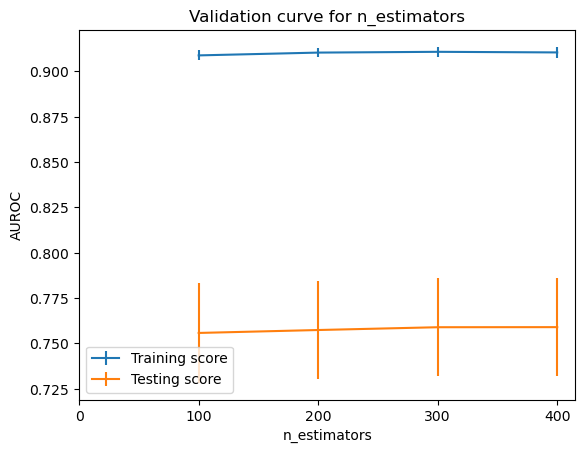

In [24]:
# plot validation curve for n_estimators
plt.errorbar(n_estimators_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(n_estimators_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 500, 100))
plt.xlabel("n_estimators")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for n_estimators")

In [25]:
pipeline.set_params(randomforestclassifier__n_estimators=400)

# generate validation curve for max_features
max_features_values = [0.1, 0.2, 0.3, 0.4]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestclassifier__max_features', 
    param_range=max_features_values, scoring='roc_auc', n_jobs=2)

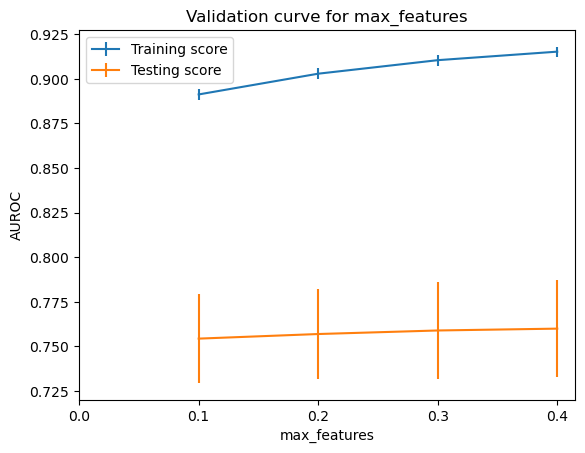

In [26]:
# plot validation curve for max_features
plt.errorbar(max_features_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_features_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 0.5, 0.1))
plt.xlabel("max_features")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for max_features")

In [27]:
pipeline.set_params(randomforestclassifier__max_features=0.4)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [16, 32, 64, 128, 256]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestclassifier__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='roc_auc', n_jobs=2)

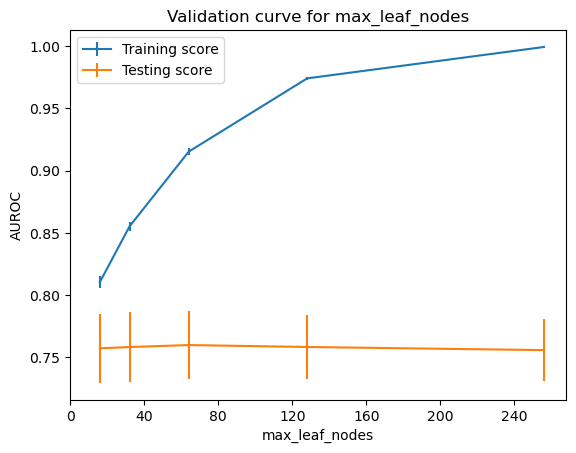

In [28]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 280, 40))
plt.xlabel("max_leaf_nodes")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for max_leaf_nodes")

We will proceed with max_leaf_nodes of 64, n_estimators of 400, and max_features of 0.4.

In [29]:
pipeline.set_params(randomforestclassifier__max_features=0.4)
pipeline.set_params(randomforestclassifier__max_leaf_nodes=64)
pipeline.set_params(randomforestclassifier__n_estimators=400)

# get results from tuned model
rfc_results = cross_validate(pipeline, features, target, 
                             scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val)

print('The mean accuracy with cross-validation is: ' 
      f'{rfc_results["test_accuracy"].mean():.3f} +/- {rfc_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{rfc_results["test_precision"].mean():.3f} +/- {rfc_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{rfc_results["test_recall"].mean():.3f} +/- {rfc_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{rfc_results["test_roc_auc"].mean():.3f} +/- {rfc_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.715 +/- 0.022
The mean precision with cross-validation is: 0.550 +/- 0.034
The mean recall with cross-validation is: 0.605 +/- 0.048
The mean AUROC with cross-validation is: 0.755 +/- 0.027


### Gradient boosting decision trees model

In [30]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [31]:
# hyperparameter tuning

# have to manually adjust weights to correct for class imbalance
# since HistGradientBoostingClassifier doesn't have a built-in class_weight parameter
sample_weights = compute_sample_weight(class_weight='balanced', y=target)

# define algorithm
hgbc = HistGradientBoostingClassifier(random_state=0, categorical_features=[0,1,2], learning_rate=0.1)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, hgbc)

# hyperparameter values to try
param_grid =  {
    'histgradientboostingclassifier__max_iter': [50, 100, 150, 200, 250],
    'histgradientboostingclassifier__max_leaf_nodes': [8, 16, 32, 64, 128, 256]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='roc_auc', n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, 
                            fit_params={'histgradientboostingclassifier__sample_weight': sample_weights}, 
                            return_estimator=True)

In [32]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with accuracy of {cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with accuracy of 0.736
Best hyperparameters for split #2:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with accuracy of 0.763
Best hyperparameters for split #3:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with accuracy of 0.806
Best hyperparameters for split #4:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with accuracy of 0.736
Best hyperparameters for split #5:
{'histgradientboostingclassifier__max_iter': 50, 'histgradientboostingclassifier__max_leaf_nodes': 8}
with accuracy of 0.734


Let's examine max_leaf_nodes while holding max_iter at 50.

In [33]:
pipeline.set_params(histgradientboostingclassifier__max_iter=50)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [4, 8, 12, 16, 20, 24]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='histgradientboostingclassifier__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='roc_auc', n_jobs=2)

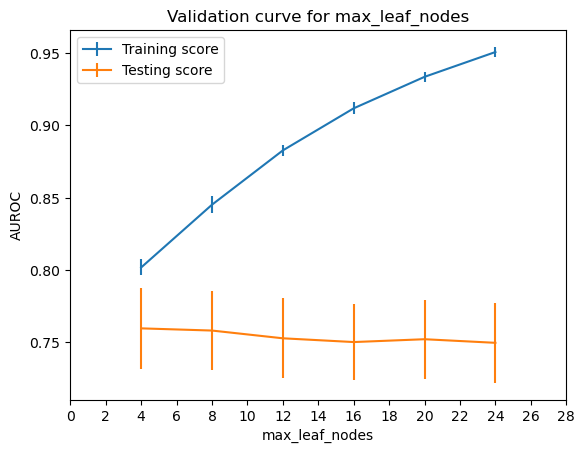

In [34]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 30, 2))
plt.xlabel("max_leaf_nodes")
plt.ylabel("AUROC")
_ = plt.title("Validation curve for max_leaf_nodes")

max_leaf_nodes of 4 appears sufficient.

In [35]:
pipeline.set_params(histgradientboostingclassifier__max_leaf_nodes=4)

# get results from tuned model
hgbc_results = cross_validate(pipeline, features, target, 
                              scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=cross_val, 
                              fit_params={'histgradientboostingclassifier__sample_weight': sample_weights})

print('The mean accuracy with cross-validation is: ' 
      f'{hgbc_results["test_accuracy"].mean():.3f} +/- {hgbc_results["test_accuracy"].std():.3f}') 
print('The mean precision with cross-validation is: ' 
      f'{hgbc_results["test_precision"].mean():.3f} +/- {hgbc_results["test_precision"].std():.3f}') 
print('The mean recall with cross-validation is: ' 
      f'{hgbc_results["test_recall"].mean():.3f} +/- {hgbc_results["test_recall"].std():.3f}') 
print('The mean AUROC with cross-validation is: ' 
      f'{hgbc_results["test_roc_auc"].mean():.3f} +/- {hgbc_results["test_roc_auc"].std():.3f}') 

The mean accuracy with cross-validation is: 0.695 +/- 0.027
The mean precision with cross-validation is: 0.518 +/- 0.033
The mean recall with cross-validation is: 0.685 +/- 0.047
The mean AUROC with cross-validation is: 0.759 +/- 0.027


### Model comparison

In [36]:
print('Dummy baseline model')
print('AUROC: ' 
      f'{dummy_results["test_roc_auc"].mean():.3f} +/- {dummy_results["test_roc_auc"].std():.3f}') 
print()
print('Logistic regression model')
print('AUROC: ' 
      f'{logreg_results["test_roc_auc"].mean():.3f} +/- {logreg_results["test_roc_auc"].std():.3f}') 
print()
print('Random forest model')
print('AUROC: ' 
      f'{rfc_results["test_roc_auc"].mean():.3f} +/- {rfc_results["test_roc_auc"].std():.3f}') 
print()
print('Gradient boosting decision trees model')
print('AUROC: ' 
      f'{hgbc_results["test_roc_auc"].mean():.3f} +/- {hgbc_results["test_roc_auc"].std():.3f}') 

Dummy baseline model
AUROC: 0.500 +/- 0.000

Logistic regression model
AUROC: 0.762 +/- 0.028

Random forest model
AUROC: 0.755 +/- 0.027

Gradient boosting decision trees model
AUROC: 0.759 +/- 0.027


((0.16427163848488274, 0.835728248277247, 1.1323787019179576e-07), <Figure size 640x480 with 1 Axes>)


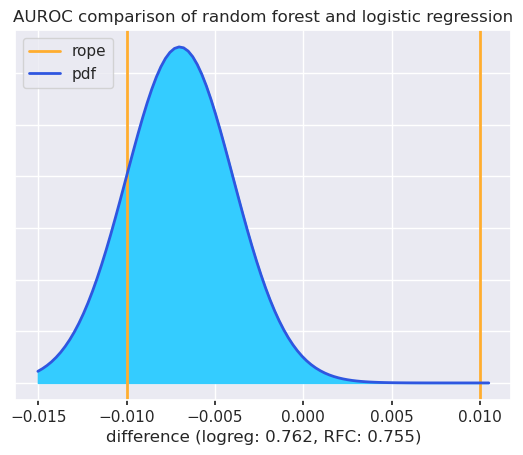

In [37]:
# statistical test comparing performance
rfc_vs_logreg = two_on_single(x=logreg_results["test_roc_auc"], y=rfc_results["test_roc_auc"], 
                                rope=0.01, runs=10, names=('logreg', 'RFC'), plot=True)
plt.title("AUROC comparison of random forest and logistic regression")
print(rfc_vs_logreg)

((0.0071577781159283035, 0.9927709982362449, 7.122364782674584e-05), <Figure size 640x480 with 1 Axes>)


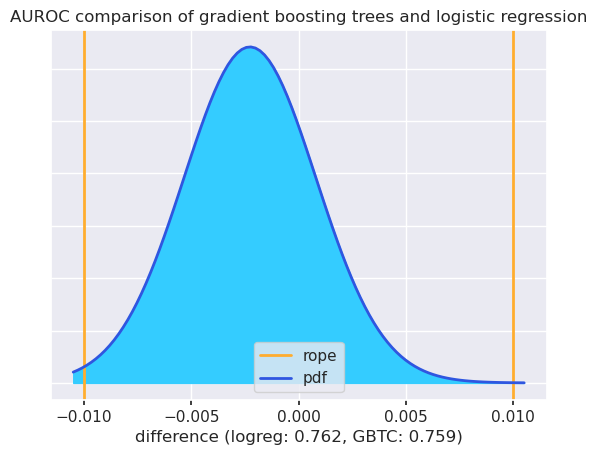

In [38]:
# statistical test comparing performance
hgbc_vs_logreg = two_on_single(x=logreg_results["test_roc_auc"], y=hgbc_results["test_roc_auc"], 
                                rope=0.01, runs=10, names=('logreg', 'GBTC'), plot=True)
plt.title("AUROC comparison of gradient boosting trees and logistic regression")
print(hgbc_vs_logreg)

## nssi_year

In [4]:
# drop records missing nssi_year for nssi_year models
nssi_year_data = data.dropna(subset='nssi_year')

# confirm new size of data set
nssi_year_data.shape

(2401, 18)

In [5]:
# define target
target = nssi_year_data['nssi_year']

# define features
features = nssi_year_data[['loneliness', 'depression', 'sex', 'gender', 'orientation', 'behav_act',
                   'hope', 'hopelessness', 'child_adverse', 'peer_vict', 'discrimination', 
                   'anxiety']].copy()

# define numeric and categorical features
numeric_columns = features.select_dtypes(include=['float64']).columns
categorical_columns = features.select_dtypes(include=['object']).columns

# define imputer
imputer = KNNImputer(n_neighbors=5)

# define cross validation procedure
cross_val = RepeatedKFold(n_splits=10, n_repeats=10, random_state=0)

### Dummy baseline model

In [6]:
# always predict most frequent target class
dummy_results = cross_validate(DummyRegressor(strategy='median'), features, target, 
                               scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                               cv=cross_val)
print('The mean RMSE with cross-validation is: ' 
      f'{-dummy_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {dummy_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-dummy_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {dummy_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 94.948 +/- 26.975
The mean Poisson deviance with cross-validation is: 153.502 +/- 54.303


In [28]:
# compute target predictions for later plots
model = DummyRegressor(strategy='median')
model.fit(features, target)
target_predicted_dummy = model.predict(features)

### Poisson regression model

In [29]:
# define preprocessor to encode categorical features and scale numeric features
preprocessor = ColumnTransformer([
    ('categorical', OneHotEncoder(handle_unknown = 'ignore'), categorical_columns), 
    ('numeric', StandardScaler(), numeric_columns)])

In [30]:
# define algorithm
poisson = PoissonRegressor()

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, poisson)

In [13]:
# hyperparameter tuning
# hyperparameter values to try
param_grid =  {
    'poissonregressor__alpha': [0.1, 0.5, 1, 2, 5, 10]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_poisson_deviance', n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, return_estimator=True)

In [14]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with Poisson deviance of {-cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'poissonregressor__alpha': 5}
with RMSE of 72.364
Best hyperparameters for split #2:
{'poissonregressor__alpha': 5}
with RMSE of 102.558
Best hyperparameters for split #3:
{'poissonregressor__alpha': 5}
with RMSE of 70.711
Best hyperparameters for split #4:
{'poissonregressor__alpha': 5}
with RMSE of 99.379
Best hyperparameters for split #5:
{'poissonregressor__alpha': 5}
with RMSE of 45.719


alpha of 5 appears best.

In [31]:
pipeline.set_params(poissonregressor__alpha=5)

# get results from tuned model
poisson_results = cross_validate(pipeline, features, target, 
                                scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                                cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-poisson_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {poisson_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 89.900 +/- 24.933
The mean Poisson deviance with cross-validation is: 76.709 +/- 22.437


In [32]:
# compute target predictions for later plots
target_predicted_poisson = cross_val_predict(pipeline, features, target, cv=10)

### Random forest model

In [15]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [16]:
# define algorithm
rfr = RandomForestRegressor(criterion='poisson', n_jobs=2, random_state=0)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, rfr)

In [17]:
# hyperparameter values to try
param_grid =  {
    'randomforestregressor__max_leaf_nodes': [32, 64, 128, 256, 512, 1024],
    'randomforestregressor__max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    'randomforestregressor__n_estimators': [100, 200, 300, 400, 500, 600]}

randomized_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=500, 
                                       scoring='neg_mean_poisson_deviance', n_jobs=2)

cv_results = cross_validate(randomized_search, features, target, n_jobs=2, return_estimator=True)

In [18]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with Poisson deviance of {-cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'randomforestregressor__n_estimators': 200, 'randomforestregressor__max_leaf_nodes': 64, 'randomforestregressor__max_features': 0.1}
with Poisson deviance of 71.040
Best hyperparameters for split #2:
{'randomforestregressor__n_estimators': 600, 'randomforestregressor__max_leaf_nodes': 32, 'randomforestregressor__max_features': 0.1}
with Poisson deviance of 108.805
Best hyperparameters for split #3:
{'randomforestregressor__n_estimators': 600, 'randomforestregressor__max_leaf_nodes': 1024, 'randomforestregressor__max_features': 0.1}
with Poisson deviance of 79.799
Best hyperparameters for split #4:
{'randomforestregressor__n_estimators': 500, 'randomforestregressor__max_leaf_nodes': 32, 'randomforestregressor__max_features': 0.2}
with Poisson deviance of 107.475
Best hyperparameters for split #5:
{'randomforestregressor__n_estimators': 600, 'randomforestregressor__max_leaf_nodes': 32, 'randomforestregressor__max_features': 0.1}
with Poisson deviance o

We'll try a more focused search around these results.

In [19]:
pipeline.set_params(randomforestregressor__max_features=0.1)
pipeline.set_params(randomforestregressor__n_estimators=600)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [16, 32, 64, 128, 256, 512, 1024]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestregressor__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='neg_mean_poisson_deviance', n_jobs=2)

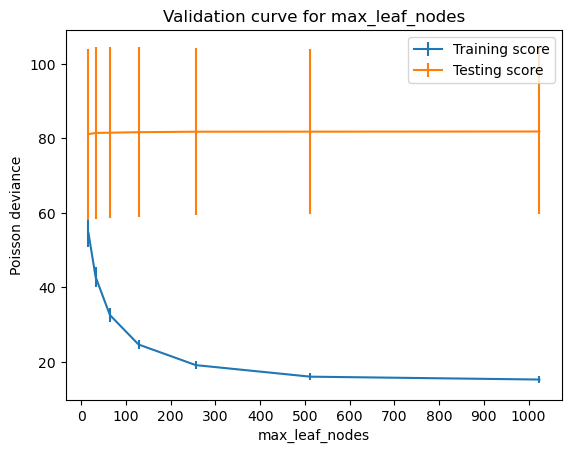

In [20]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, -train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, -test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 1100, 100))
plt.xlabel("max_leaf_nodes")
plt.ylabel("Poisson deviance")
_ = plt.title("Validation curve for max_leaf_nodes")

In [21]:
# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [8, 16, 32, 64, 128]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestregressor__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='neg_mean_poisson_deviance', n_jobs=2)

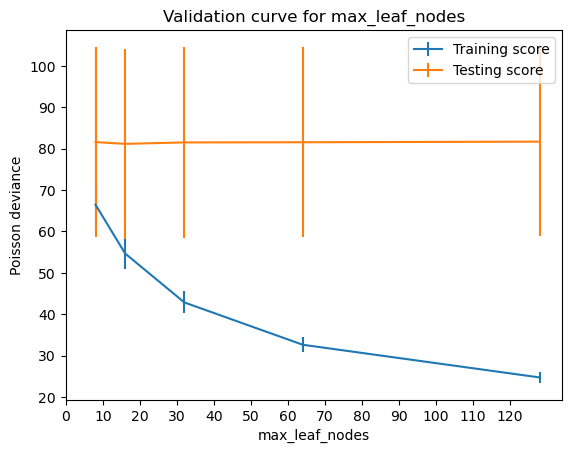

In [22]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, -train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, -test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 130, 10))
plt.xlabel("max_leaf_nodes")
plt.ylabel("Poisson deviance")
_ = plt.title("Validation curve for max_leaf_nodes")

In [23]:
pipeline.set_params(randomforestregressor__max_leaf_nodes=16)

# generate validation curve for n_estimators
n_estimators_values = [100, 200, 300, 400, 500, 600, 700]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='randomforestregressor__n_estimators', 
    param_range=n_estimators_values, scoring='neg_mean_poisson_deviance', n_jobs=2)

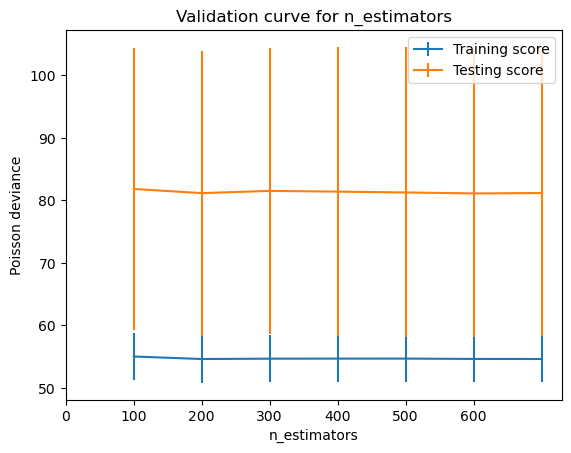

In [24]:
# plot validation curve for n_estimators
plt.errorbar(n_estimators_values, -train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(n_estimators_values, -test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 700, 100))
plt.xlabel("n_estimators")
plt.ylabel("Poisson deviance")
_ = plt.title("Validation curve for n_estimators")

We will proceed with max_leaf_nodes of 16, n_estimators of 600, and max_features of 0.1.

In [26]:
pipeline.set_params(randomforestregressor__max_features=0.1)
pipeline.set_params(randomforestregressor__max_leaf_nodes=16)
pipeline.set_params(randomforestregressor__n_estimators=600)

# get results from tuned model
rfr_results = cross_validate(pipeline, features, target, 
                             scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'],
                             cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-rfr_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {rfr_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-rfr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {rfr_results["test_neg_mean_poisson_deviance"].std():.3f}') 

C:\Users\jpowe\miniconda3\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


The mean RMSE with cross-validation is: 90.454 +/- 25.700
The mean Poisson deviance with cross-validation is: 79.922 +/- 23.484


In [27]:
# compute target predictions for later plots
target_predicted_rfr = cross_val_predict(pipeline, features, target, cv=10)

### Gradient boosting decision trees model

In [33]:
# define preprocessor to encode categorical features
preprocessor = ColumnTransformer([
    ('categorical', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1), categorical_columns)], 
    remainder = 'passthrough')

In [34]:
# hyperparameter tuning

# define algorithm
hgbr = HistGradientBoostingRegressor(loss='poisson', random_state=0, 
                                     categorical_features=[0,1,2], learning_rate=0.1)

# assemble steps into pipeline
pipeline = make_pipeline(preprocessor, imputer, hgbr)

# hyperparameter values to try
param_grid =  {
    'histgradientboostingregressor__max_iter': [50, 100, 150, 200, 250],
    'histgradientboostingregressor__max_leaf_nodes': [8, 16, 32, 64, 128, 256]}

grid_search = GridSearchCV(pipeline, param_grid=param_grid, scoring='neg_mean_poisson_deviance', n_jobs=2)

cv_results = cross_validate(grid_search, features, target, n_jobs=2, return_estimator=True)

In [35]:
# get best values of hyperparameters for each split of outer cross-validation
for cv_split, estimator_in_split in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for split #{cv_split + 1}:\n"
        f"{estimator_in_split.best_params_}\n"
        f"with Poisson deviance of {-cv_results['test_score'][cv_split]:.3f}"
    )

Best hyperparameters for split #1:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 79.004
Best hyperparameters for split #2:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 16}
with Poisson deviance of 111.781
Best hyperparameters for split #3:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 80.207
Best hyperparameters for split #4:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 109.205
Best hyperparameters for split #5:
{'histgradientboostingregressor__max_iter': 50, 'histgradientboostingregressor__max_leaf_nodes': 8}
with Poisson deviance of 47.318


Let's examine max_leaf_nodes while holding max_iter at 50.

In [36]:
pipeline.set_params(histgradientboostingregressor__max_iter=50)

# generate validation curve for max_leaf_nodes
max_leaf_nodes_values = [4, 8, 16, 32, 48]
train_scores, test_scores = validation_curve(
    pipeline, features, target, param_name='histgradientboostingregressor__max_leaf_nodes', 
    param_range=max_leaf_nodes_values, scoring='neg_mean_poisson_deviance', n_jobs=2)

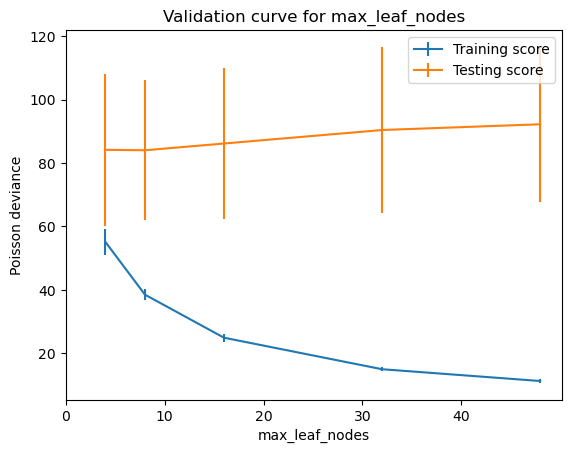

In [37]:
# plot validation curve for max_leaf_nodes
plt.errorbar(max_leaf_nodes_values, -train_scores.mean(axis=1), yerr=train_scores.std(axis=1), label="Training score")
plt.errorbar(max_leaf_nodes_values, -test_scores.mean(axis=1), yerr=test_scores.std(axis=1), label="Testing score")
plt.legend()
plt.xticks(np.arange(0, 50, 10))
plt.xlabel("max_leaf_nodes")
plt.ylabel("Poisson deviance")
_ = plt.title("Validation curve for max_leaf_nodes")

max_leaf_nodes of 8 appears sufficient.

In [38]:
pipeline.set_params(histgradientboostingregressor__max_leaf_nodes=8)

# get results from tuned model
hgbr_results = cross_validate(pipeline, features, target, 
                              scoring=['neg_root_mean_squared_error', 'neg_mean_poisson_deviance'], 
                              cv=cross_val)

print('The mean RMSE with cross-validation is: ' 
      f'{-hgbr_results["test_neg_root_mean_squared_error"].mean():.3f} \
+/- {hgbr_results["test_neg_root_mean_squared_error"].std():.3f}') 
print('The mean Poisson deviance with cross-validation is: ' 
      f'{-hgbr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {hgbr_results["test_neg_mean_poisson_deviance"].std():.3f}') 

The mean RMSE with cross-validation is: 92.869 +/- 24.119
The mean Poisson deviance with cross-validation is: 82.874 +/- 24.614


In [39]:
# compute target predictions for later plots
target_predicted_hgbr = cross_val_predict(pipeline, features, target, cv=10)

### Model comparison

In [40]:
print('Dummy baseline model')
print('Poisson deviance: ' 
      f'{-dummy_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {dummy_results["test_neg_mean_poisson_deviance"].std():.3f}') 
print()
print('Poisson model')
print('Poisson deviance: ' 
      f'{-poisson_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {poisson_results["test_neg_mean_poisson_deviance"].std():.3f}') 
print()
print()
print('Random forest model')
print('Poisson deviance: ' 
      f'{-rfr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {rfr_results["test_neg_mean_poisson_deviance"].std():.3f}') 
print()
print()
print('Gradient boosting decision trees model')
print('Poisson deviance: ' 
      f'{-hgbr_results["test_neg_mean_poisson_deviance"].mean():.3f} \
+/- {hgbr_results["test_neg_mean_poisson_deviance"].std():.3f}') 
print()

Dummy baseline model
Poisson deviance: 153.502 +/- 54.303

Poisson model
Poisson deviance: 76.709 +/- 22.437


Random forest model
Poisson deviance: 79.922 +/- 23.484


Gradient boosting decision trees model
Poisson deviance: 82.874 +/- 24.614



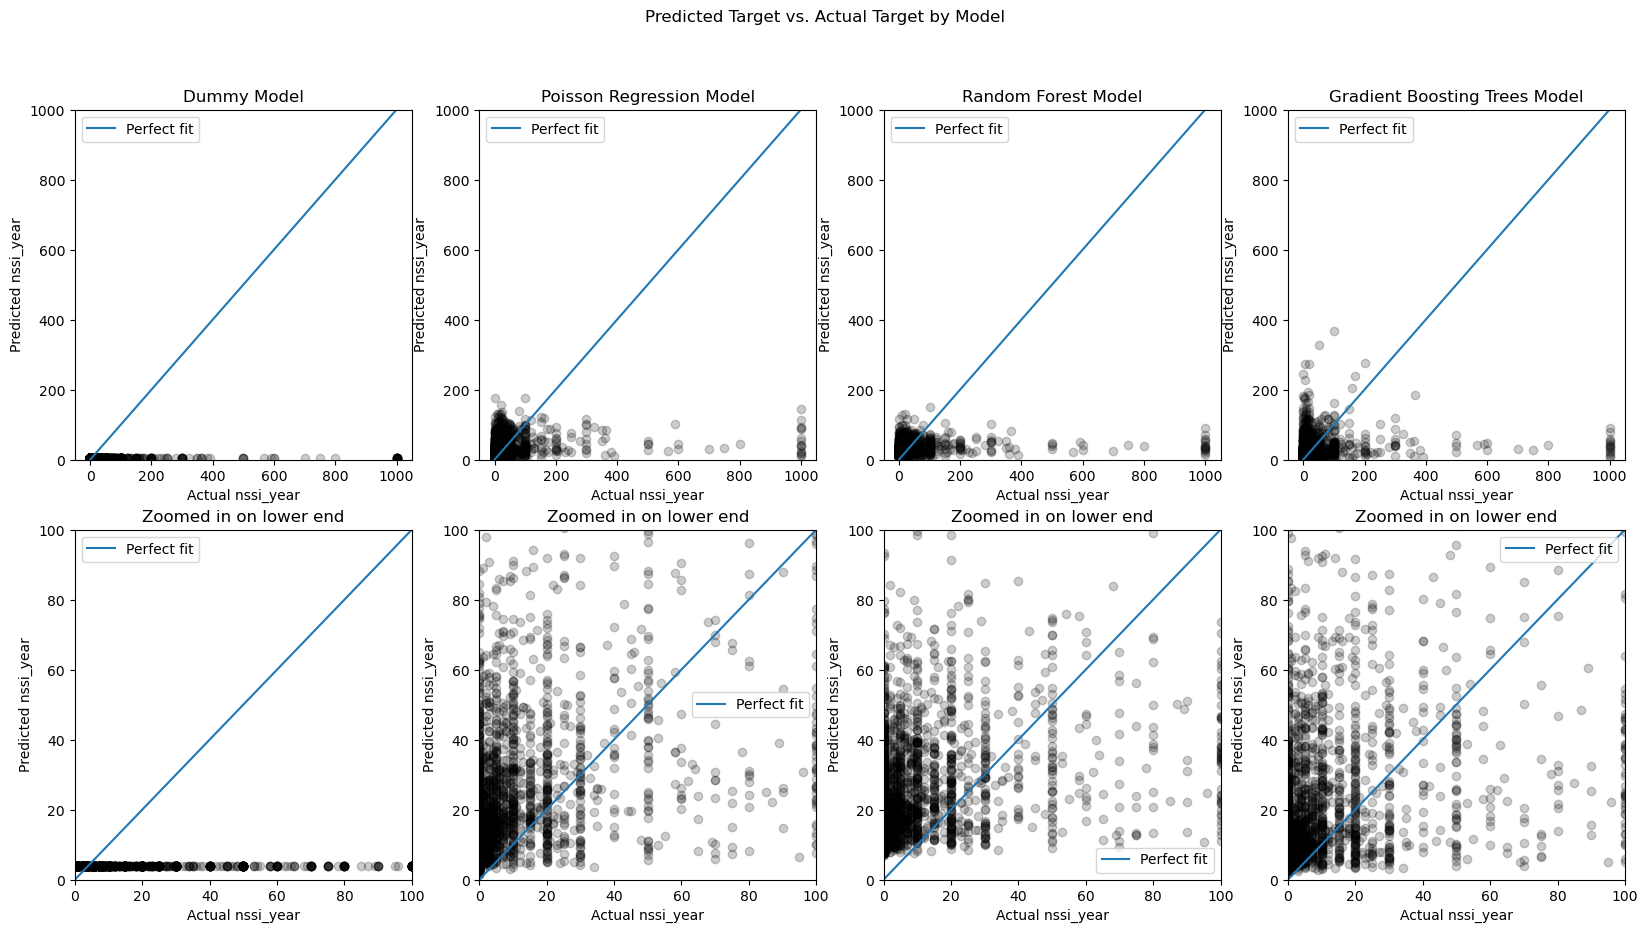

In [45]:
# plot predicted target vs. actual target
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Predicted Target vs. Actual Target by Model')

axes[0,0].scatter(target, target_predicted_dummy, alpha = 0.2, color='k')
axes[0,0].set_ylim(min(target), max(target))
axes[0,0].set_xlabel("Actual nssi_year")
axes[0,0].set_ylabel("Predicted nssi_year")
axes[0,0].axline((0, 0), slope=1, label="Perfect fit")
axes[0,0].legend()
axes[0,0].set_title("Dummy Model")

axes[1,0].scatter(target, target_predicted_dummy, alpha = 0.2, color='k')
axes[1,0].set_xlim(min(target), 100)
axes[1,0].set_ylim(min(target), 100)
axes[1,0].set_xlabel("Actual nssi_year")
axes[1,0].set_ylabel("Predicted nssi_year")
axes[1,0].axline((0, 0), slope=1, label="Perfect fit")
axes[1,0].legend()
axes[1,0].set_title("Zoomed in on lower end")

axes[0,1].scatter(target, target_predicted_poisson, alpha = 0.2, color='k')
axes[0,1].set_ylim(min(target), max(target))
axes[0,1].set_xlabel("Actual nssi_year")
axes[0,1].set_ylabel("Predicted nssi_year")
axes[0,1].axline((0, 0), slope=1, label="Perfect fit")
axes[0,1].legend()
axes[0,1].set_title("Poisson Regression Model")

axes[1,1].scatter(target, target_predicted_poisson, alpha = 0.2, color='k')
axes[1,1].set_xlim(min(target), 100)
axes[1,1].set_ylim(min(target), 100)
axes[1,1].set_xlabel("Actual nssi_year")
axes[1,1].set_ylabel("Predicted nssi_year")
axes[1,1].axline((0, 0), slope=1, label="Perfect fit")
axes[1,1].legend()
axes[1,1].set_title("Zoomed in on lower end")

axes[0,2].scatter(target, target_predicted_rfr, alpha = 0.2, color='k')
axes[0,2].set_ylim(min(target), max(target))
axes[0,2].set_xlabel("Actual nssi_year")
axes[0,2].set_ylabel("Predicted nssi_year")
axes[0,2].axline((0, 0), slope=1, label="Perfect fit")
axes[0,2].legend()
axes[0,2].set_title("Random Forest Model")

axes[1,2].scatter(target, target_predicted_rfr, alpha = 0.2, color='k')
axes[1,2].set_xlim(min(target), 100)
axes[1,2].set_ylim(min(target), 100)
axes[1,2].set_xlabel("Actual nssi_year")
axes[1,2].set_ylabel("Predicted nssi_year")
axes[1,2].axline((0, 0), slope=1, label="Perfect fit")
axes[1,2].legend()
axes[1,2].set_title("Zoomed in on lower end")

axes[0,3].scatter(target, target_predicted_hgbr, alpha = 0.2, color='k')
axes[0,3].set_ylim(min(target), max(target))
axes[0,3].set_xlabel("Actual nssi_year")
axes[0,3].set_ylabel("Predicted nssi_year")
axes[0,3].axline((0, 0), slope=1, label="Perfect fit")
axes[0,3].legend()
axes[0,3].set_title("Gradient Boosting Trees Model")

axes[1,3].scatter(target, target_predicted_hgbr, alpha = 0.2, color='k')
axes[1,3].set_xlim(min(target), 100)
axes[1,3].set_ylim(min(target), 100)
axes[1,3].set_xlabel("Actual nssi_year")
axes[1,3].set_ylabel("Predicted nssi_year")
axes[1,3].axline((0, 0), slope=1, label="Perfect fit")
axes[1,3].legend()
axes[1,3].set_title("Zoomed in on lower end")

None

((0.0036903298319959804, 0.0732329457241041, 0.9230767244438999), <Figure size 640x480 with 1 Axes>)


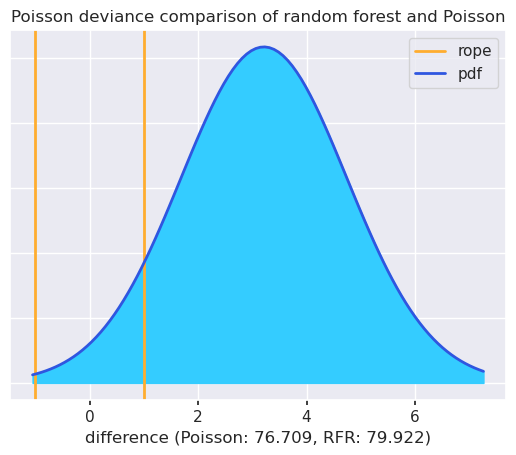

In [46]:
# statistical test comparing performance
rfr_vs_poisson = two_on_single(x=-poisson_results["test_neg_mean_poisson_deviance"], 
                               y=-rfr_results["test_neg_mean_poisson_deviance"], 
                                rope=1, runs=10, names=('Poisson', 'RFR'), plot=True)
plt.title("Poisson deviance comparison of random forest and Poisson")
print(rfr_vs_poisson)

((7.690166663849808e-05, 0.0026799731749785893, 0.9972431251583829), <Figure size 640x480 with 1 Axes>)


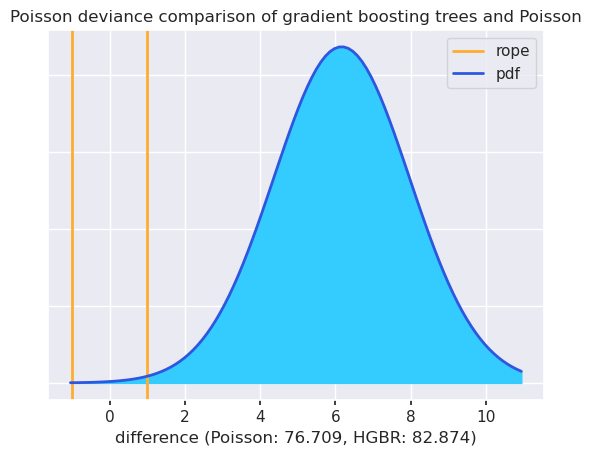

In [47]:
# statistical test comparing performance
hgbr_vs_poisson = two_on_single(x=-poisson_results["test_neg_mean_poisson_deviance"], 
                                y=-hgbr_results["test_neg_mean_poisson_deviance"], 
                                rope=1, runs=10, names=('Poisson', 'HGBR'), plot=True)
plt.title("Poisson deviance comparison of gradient boosting trees and Poisson")
print(hgbr_vs_poisson)

# Sandbox

In [ ]:
# define function to compute permutation feature importances
# perm_n: number of iterations of permutation feature importance procedure to aggregate
def perm_feat_imp(pipeline, perm_n=25):
    
    # create dataframe to store results
    perm_results_df = pd.DataFrame(index=features.columns, columns=range(perm_n))
    
    for i in range(perm_n):

        # split data for permutation importance computation
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

        # permutation importance computation
        pipeline.fit(X_train, y_train)
        perm_results = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=0, n_jobs=2)

        # store results in a dataframe and sort
        perm_results_df.iloc[:, i] = perm_results.importances_mean
        
    # summarize results over iterations
    perm_results_summary = pd.DataFrame(index=features.columns)
    perm_results_summary['mean'] = perm_results_df.mean(axis=1)
    perm_results_summary['std'] = perm_results_df.std(axis=1)
    perm_results_summary.sort_values('mean', ascending=False, inplace=True)
    
    return perm_results_df, perm_results_summary

In [ ]:
# define function to compute feature rank instability
# how much feature rank changes over aggregations of successively larger number of permutation importance iterations
def rank_instability(perm_results_df):
    instability = pd.Series(index=range(2,26), dtype='float')
    
    # compute feature rank instability between 1st iteration and the aggregation of the 1st 2 iterations
    agg1 = perm_results_df.iloc[:, 0].rank(ascending=False)
    agg2 = perm_results_df.iloc[:, 0:2].mean(axis=1).rank(ascending=False)
    instability[2] = abs(agg2 - agg1).mean()
    
    # compute feature rank instability between successive aggregations
    for i in range(3,26):
        agg1 = perm_results_df.iloc[:, 0:(i-1)].mean(axis=1).rank(ascending=False)
        agg2 = perm_results_df.iloc[:, 0:i].mean(axis=1).rank(ascending=False)
        instability[i] = abs(agg2 - agg1).mean()
        
    return instability

                    mean       std
depression      0.023715  0.012450
orientation     0.019560  0.010518
child_adverse   0.008888  0.010181
gender          0.008815  0.009904
sex             0.008269  0.007256
discrimination  0.004725  0.010667
hope            0.002550  0.006585
hopelessness   -0.001255  0.003289
behav_act      -0.001564  0.003408
anxiety        -0.001841  0.006726
loneliness     -0.002941  0.004075
peer_vict      -0.003365  0.005234


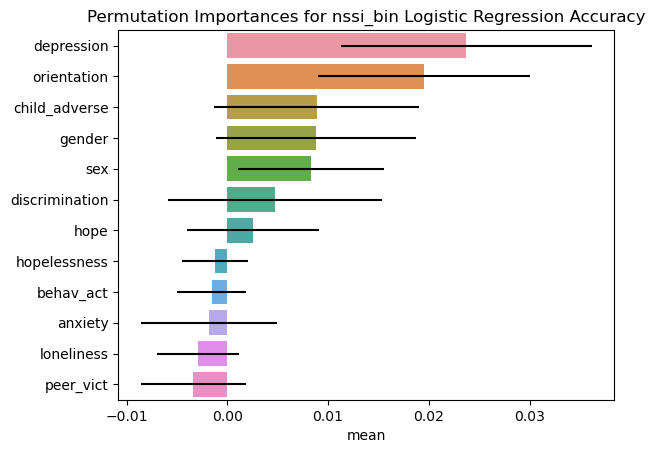

In [25]:
# set number of permutation importance iterations
perm_n = 25

# create dataframe to store results
perm_results_df = pd.DataFrame(index=features.columns, columns=range(perm_n))

for i in range(perm_n):

    # split data for permutation importance computation
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

    # permutation importance computation
    pipeline.fit(X_train, y_train)
    perm_results = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=0, n_jobs=2)

    # store results in a dataframe and sort
    perm_results_df.iloc[:, i] = perm_results.importances_mean

# summarize results over iterations
perm_results_summary = pd.DataFrame(index=features.columns)
perm_results_summary['mean'] = perm_results_df.mean(axis=1)
perm_results_summary['std'] = perm_results_df.std(axis=1)
perm_results_summary.sort_values('mean', ascending=False, inplace=True)
        
# view results
print(perm_results_summary)
plt.title("Permutation Importances for nssi_bin Logistic Regression Accuracy")
sns.barplot(x=perm_results_summary['mean'], y=perm_results_summary.index, xerr=perm_results_summary['std'])

None

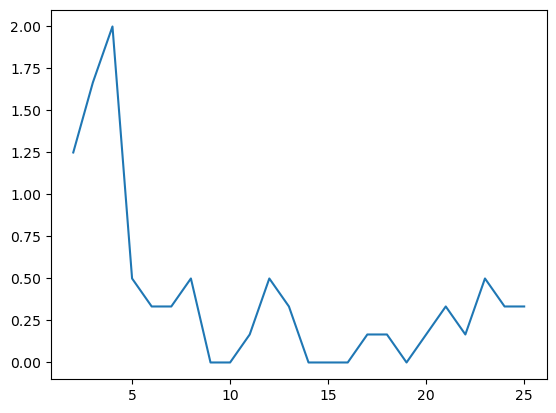

In [63]:
# feature rank instability plot
# how much feature rank changes over aggregations of successively larger number of permutation importance iterations
instability = pd.Series(index=range(2,26), dtype='float')

# compute feature rank instability between 1st iteration and the aggregation of the 1st 2 iterations
agg1 = perm_results_df.iloc[:, 0].rank(ascending=False)
agg2 = perm_results_df.iloc[:, 0:2].mean(axis=1).rank(ascending=False)
instability[2] = abs(agg2 - agg1).mean()

# compute feature rank instability between successive aggregations
for i in range(3,26):
    agg1 = perm_results_df.iloc[:, 0:(i-1)].mean(axis=1).rank(ascending=False)
    agg2 = perm_results_df.iloc[:, 0:i].mean(axis=1).rank(ascending=False)
    instability[i] = abs(agg2 - agg1).mean()

# plot feature rank instability    
plt.plot(instability.index, instability)
plt.xlabel("Iterations Aggregated")
plt.ylabel("Feature Rank Instability")
plt.title("Feature Rank Instability")
None

In [49]:
data[data['nssi_year'] == 0].shape

(926, 18)

In [50]:
data[data['si_year'] == 0].shape

(571, 18)

In [51]:
data[data['attempt_year'] == 0].shape

(1976, 18)